# Supplementary Aanalyses & Results

.. info ..

## R version

In [1]:
version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          4                           
minor          0.0                         
year           2020                        
month          04                          
day            24                          
svn rev        78286                       
language       R                           
version.string R version 4.0.0 (2020-04-24)
nickname       Arbor Day                   

## Libraries and functions

In [51]:
# Dace Apšvalka @MRC-CBU, 2019-2020
# ----------------------------------------------------------------------
# LIBRARIES
# ----------------------------------------------------------------------
shhh <- suppressPackageStartupMessages # It's a library, so shhh!
library(Hmisc) 
library(plyr)      # for ddply (aggregating SST results)
library(pastecs)   # for summary statistic
library(ggplot2)   # for plotting results
library(repr)      # for changing plot size (default too large in notebook)
library(gridExtra) # for adding plots together
library(grid)      # for plot grid title formatting
library(aplpack)   # for bi-variate outlier, bgplot
library(robust)    # for robust correlation
shhh(suppressWarnings(library(tidyr))) # for creating long table (function gather)
library(WRS2)      # for percentage bend correlation coefficient 
                   #   https://link-springer-com.ezp.lib.cam.ac.uk/content/pdf/10.1007/BF02294395.pdf
library(WRS)       # for Wilcox correlation functions (skipped correlations)
                   #     Wilcox R. R. (2005). Introduction to Robust Estimation and Hypothesis Testing. 
                   #                          New York, NY: Elsevier Academic Press
                   #     https://www-ncbi-nlm-nih-gov.ezp.lib.cam.ac.uk/pmc/articles/PMC3342588/

# ----------------------------------------------------------------------
# FUNCTIONS
# ----------------------------------------------------------------------

# PLOT MEANS, Group mean (with 95%CI) and subject values
# =======================================================
plotResults <- function(dataset, x, group, title, units, extraTxt) {
  ggplot(dataset, aes(group, x)) +
    geom_point(
      colour = "black", alpha = .9, fill = 'grey',
      size = 1, stroke = 0.1, shape = 21,
      position = position_jitter(height = 0, width = 0.1)
    ) +
    stat_summary(
      fun.data = mean_cl_boot,
      geom = "pointrange",
      fill = 'red', alpha = 0.8, color = "black",
      size = 0.6, stroke = 0.3, shape = 21,
      position = position_nudge(x = -0.2)
    ) +
    # scale_x_discrete() +
    labs(x = extraTxt, y = units) + ggtitle(title) +
    theme_minimal() +
    theme(text = element_text(size = 9), 
          plot.title = element_text(hjust = 0.5, size = 9, face="bold"), 
          plot.background = element_rect(color = "lightgrey", size = 0.4, linetype = "dotted"), 
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()
    )
}
# GET OUTLIERS (from a variable pair, for correlations)
# =======================================================
get_outliers <-
  function(var1,var1name,var1y,
           var2,var2name,var2y,
           disp) {
    par(mfrow = c(1, 3)) # to put the 2 univariate and 1 bivariate plots together
    
    # UNIVARIATE, boxplot method
    # ------------------------------------
    bpVar1 <- boxplot(var1,main = var1name,ylab = var1y,plot = disp)
    bpVar2 <- boxplot(var2,main = var2name,ylab = var2y,plot = disp)
    # oVar1
    ifelse(length(bpVar1$out) == 0,
      oVar1 <- vector(mode = "numeric", length = 0),
      oVar1 <- which(var1 %in% bpVar1$out)
    )
    # oVar2
    ifelse(length(bpVar2$out) == 0,
      oVar2 <- vector(mode = "numeric", length = 0),
      oVar2 <- which(var2 %in% bpVar2$out)
    )
    
    # BI-VARIATE, bagplot method
    # ------------------------------------
    # A bagplot is a bivariate generalization of the  boxplot. A bivariate boxplot.
    bpl <- compute.bagplot(var1, var2)
    # oBiv
    ifelse(is.null(bpl$pxy.outlier),
      oBiv <- vector(mode = "numeric", length = 0),
      oBiv <- which(var1 %in% bpl$pxy.outlier[, 1])
    )
    bp <-
      bagplot(
        var1,var2,
        ylab = var2name,xlab = var1name,
        main = 'bi-variate',
        cex = 2,
        create.plot = disp
      )
    # Report results
    # ------------------------------------
    if(disp){
            # var1
            print(sprintf('%s outliers: %d', var1name, length(bpVar1$out)))
            print(oVar1)
            # var2
            print(sprintf('%s outliers: %d', var2name, length(bpVar2$out)))
            print(oVar2)
            # bi-var
            print(sprintf('Bi-variate outliers: %d', length(oBiv)))
            print(oBiv)
        }
    # Return results
    # ------------------------------------
    all        <- c(oVar1, oVar2, oBiv)
    univariate <- c(oVar1, oVar2)
    bivariate  <- oBiv
    return(list(all, univariate, bivariate))
  }
# =======================================================

# DO CORRELATIONS 
# Depending on the data, 3 types of correlations possible. Following recommendations by Pernet et al.(2013)
# =======================================================
doCorrelation <- function(var1, var2, outliers) {
  # WHICH CORRELATION
  # ------------------------------------
  isOutliers   <- length(outliers[[1]]) > 0
  isUnivariate <- length(outliers[[2]]) > 0
  isBivariate  <- length(outliers[[3]]) > 0
  isNormal     <- (shapiro.test(var1)$p.value > 0.05 & shapiro.test(var2)$p.value > 0.05)
  
  # if is Bivariate do Spearman skipped, using the minimum covariance determinant (MCD) estimator 
  if (isBivariate) {
    # corRes <-
    #   scorci(var1,var2,nboot = 1000,corfun = spear,plotit = FALSE)
    # r <- corRes$cor.est
    # p <- corRes$p.value
    # f <- 'Spearman skipped'
    corRes <-
      mscor(data.frame(var1,var2), corfun = spear, cop = 3)
    r <- corRes$cor[2]
    p <- 2*pt(-abs(corRes$test.stat[2]), df = length(var1)-1)
    f <- 'Spearman skipped'
    subs <- 'ss'  
  }
  
  # if is not Bivar but is Univar or is not Normal, do 20% Bend
  if (!isBivariate & (isUnivariate | isNormal)) {
    corRes <-
      pbcor(var1,var2,beta = 0.2)
    r <- corRes$cor
    p <- corRes$p.value
    f <- 'Percentage-bend'
    subs <- 'pb' 
  }
  
  # if no outliers and is normal do Pearson
  if (!isOutliers & isNormal) {
    corRes <-
      rcorr(var1,var2)
    r <- corRes$r[2]
    p <- corRes$P[2]
    f <- 'Pearson'
    subs <- ''  
  }

  corResTxt <- bquote(.(f) ~ "correlation" ~ r[.(subs)] == .(sprintf("%.3f, p = %.3f",r,p)))
  return(corResTxt)
}
# =======================================================

# PLOT CORRELATIONS (with 95%CI)
# ------------------------------------
plotCorrelation <- function(var1, var2, var1name, var2name, resTXT, pointsize, txtsize, outliers=NULL) {
  if(!is.null(outliers) & length(outliers[[1]]) > 0) {
    var1 <- var1[-c(outliers[[1]])]
    var2 <- var2[-c(outliers[[1]])]
    addTxt <- sprintf('\n Outliers (n=%d) not displayed',length(unique(outliers[[1]])))      
     resTXT <- bquote(atop(.(resTXT), .(addTxt)))      
      #paste(resTXT, sprintf('\n Outliers (n=%d) not displayed',length(unique(outliers[[1]]))))
  }
  dataset <- data.frame(var1, var2)
  
  ggplot(dataset, aes(var1, var2)) +
    geom_smooth(
      method = lm, formula = y ~ x, level = 0.95,
      color = "black", fill = "grey", size = 0.2
    ) +
    geom_point(
      colour = "black", alpha = .9, fill = 'grey',
      size = pointsize, stroke = 0.2, shape = 21
    ) +
    labs(x = var1name, y = var2name, title = resTXT) + 
    theme_minimal() + 
    theme(text = element_text(size = txtsize), 
          plot.title = element_text(hjust = 0.5, size = 9, face="bold"), 
          plot.background = element_rect(colour = "lightgrey", size = 0.4, linetype = "dotted"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank()
    )
}
# =======================================================

## Load the data

In [3]:
# ----------------------------------------------------------------------
# LOAD DATA
# ----------------------------------------------------------------------

# SST
dataSST <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/SSTraw.csv')
# exclude Go only runs from the analysis
dataSST <- subset(dataSST, cond == '2') 

# TNT
dataTNT <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/TNT.csv')
# turn test values into percentages
dataTNT[, 10:ncol(dataTNT)] <- dataTNT[, 10:ncol(dataTNT)] * 100

# tfSSRT: SSRTs with Stop trigger failures
data_tfSSRT <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/TF_SSRT.csv')

# Behavioural performance

## Stop-signal task performance

### Stop-signal analysis function

In [4]:
# STOP-SIGNAL ANALYSIS
# Based on: Verbruggen et al (2019). https://doi.org/10.7554/eLife.46323.001
# ------------------------------------
funcSignal <- function(data) {
  # all trials with a Response (any)
  data$resp <- ifelse(data$gRT == "0", 0, 1)
  
  # Stop-signal trials
  # ----------------------------------------------------------------------
  # All
  signal <- subset(data, gkind == '1')
  # probability of responding to the Stop-Signal
  presp <-  mean(signal$resp)
  # mean Stop-Signal Delay (of all Stop-Signal trials)
  ssd <- mean(signal$gintVal)
  # unsuccessful Stop RTs
  signal.resp    <- subset(signal, resp == '1')
  signal.resp.rt <- mean(signal.resp$gRT)
  
  # Go trials
  # ----------------------------------------------------------------------
  # All
  nosignal <- subset(data, gkind == '0') 
  # With response
  nosignal_resp <- subset(nosignal, resp == '1') 
  # probability of Go omossions
  pmiss <- 1-mean(nosignal$resp)
  # Correct Go trials
  nosignal_resp$error <-
    ifelse(nosignal_resp$gtheButton == nosignal_resp$gresp, 0, 1)
  # Probability of Go choice errors
  perror <- mean(nosignal_resp$error)
  # for the missed responses, set RT to max RT of the subject
  nosignal$gRT <-
    ifelse(nosignal$gRT == 0, max(nosignal_resp$gRT), nosignal$gRT)
  # RT for Go trials with a response
  nosignal.resp.rt <- mean(nosignal_resp$gRT)
  # RT for correct Go trials
  nosignal.correctresp <- subset(nosignal_resp, error == '0')
  nosignal.correctresp.rt <- mean(nosignal.correctresp$gRT)
  
  # SSRT
  # ----------------------------------------------------------------------
  # All Go trials are included when the nth RT is determined
  ## determine nth RT
  nthRT_all <- quantile(nosignal$gRT, probs = presp, type = 6)
  ## SSRT(integration) = nthRT - ssd
  SSRTall <- nthRT_all - ssd
  
  # Race Check
  # ----------------------------------------------------------------------
  # All Go trials
    # "..this comparison should include all trials with a response 
    # (including choice errors and premature responses).." 
    # (Verbruggen et al., 2019))
  race.check <- nosignal.resp.rt - signal.resp.rt
  
  # Output
  # ----------------------------------------------------------------------
  return(
    data.frame(
      Ntrials = nrow(data),
      NStop = sum(signal$gkind),
      ssPerc = sum(signal$gkind)/nrow(data)*100,
      presp, pmiss, perror, 
      SSD = ssd,
      SSRT = SSRTall,
      sRT = signal.resp.rt,
      goRTcorr = nosignal.correctresp.rt,
      goRTall = nosignal.resp.rt,  
      raceCheck = race.check
    )
  )
}

### Summary data and decriptives

In [5]:
# ======================================================================
# SST RESULTS
# ======================================================================
# By Subject aggregated
# ----------------------------------------------------------------------
dataSSTsubj <- ddply(dataSST, .(sNR), funcSignal)
# display
print(round(dataSSTsubj,2))

   sNR Ntrials NStop ssPerc presp pmiss perror    SSD   SSRT    sRT goRTcorr
1    1     384   123  32.03  0.37  0.00   0.00 291.87 295.13 570.64   612.05
2    2     384   123  32.03  0.50  0.00   0.02 219.51 402.42 606.59   633.24
3    3     336   110  32.74  0.44  0.01   0.04 258.18 367.98 642.02   669.21
4    4     384   121  31.51  0.42  0.00   0.02 248.35 288.93 509.04   562.74
5    5     384   119  30.99  0.46  0.00   0.03 243.28 296.72 516.98   581.51
6    6     384   111  28.91  0.58  0.00   0.05 219.82 400.16 569.00   609.02
7    7     384   111  28.91  0.53  0.00   0.02 236.94 307.06 481.66   559.78
8    8     384   126  32.81  0.56  0.00   0.03 188.10 318.90 494.49   509.12
9    9     336   106  31.55  0.69  0.00   0.06 148.11 443.14 533.47   569.88
10  10     384   115  29.95  0.47  0.00   0.04 232.17 282.83 507.52   547.02
11  11     384   131  34.11  0.36  0.00   0.03 291.22 314.91 598.87   645.61
12  12     384   125  32.55  0.50  0.00   0.04 239.20 371.76 592.69   637.09

In [6]:
# Descriptives
# ----------------------------------------------------------------------
dscrSST <- stat.desc(dataSSTsubj[, 2:ncol(dataSSTsubj)],  basic = TRUE, desc = TRUE, p = 0.95)
print(round(dscrSST, 2))

             Ntrials   NStop ssPerc presp pmiss perror     SSD    SSRT      sRT
nbr.val        24.00   24.00  24.00 24.00 24.00  24.00   24.00   24.00    24.00
nbr.null        0.00    0.00   0.00  0.00 17.00   1.00    0.00    0.00     0.00
nbr.na          0.00    0.00   0.00  0.00  0.00   0.00    0.00    0.00     0.00
min           336.00  106.00  28.91  0.36  0.00   0.00  148.11  271.24   458.44
max           384.00  136.00  35.42  0.69  0.03   0.11  291.87  465.56   671.36
range          48.00   30.00   6.51  0.33  0.03   0.11  143.76  194.32   212.91
sum          9120.00 2908.00 765.33 11.71  0.06   0.97 5519.90 8360.27 13366.15
median        384.00  121.50  31.90  0.50  0.00   0.04  231.53  349.03   549.09
mean          380.00  121.17  31.89  0.49  0.00   0.04  230.00  348.34   556.92
SE.mean         2.77    1.60   0.36  0.02  0.00   0.00    7.28   10.46    11.59
CI.mean.0.95    5.72    3.32   0.74  0.03  0.00   0.01   15.07   21.64    23.97
var           183.65   61.80   3.09  0.0

### Result plots

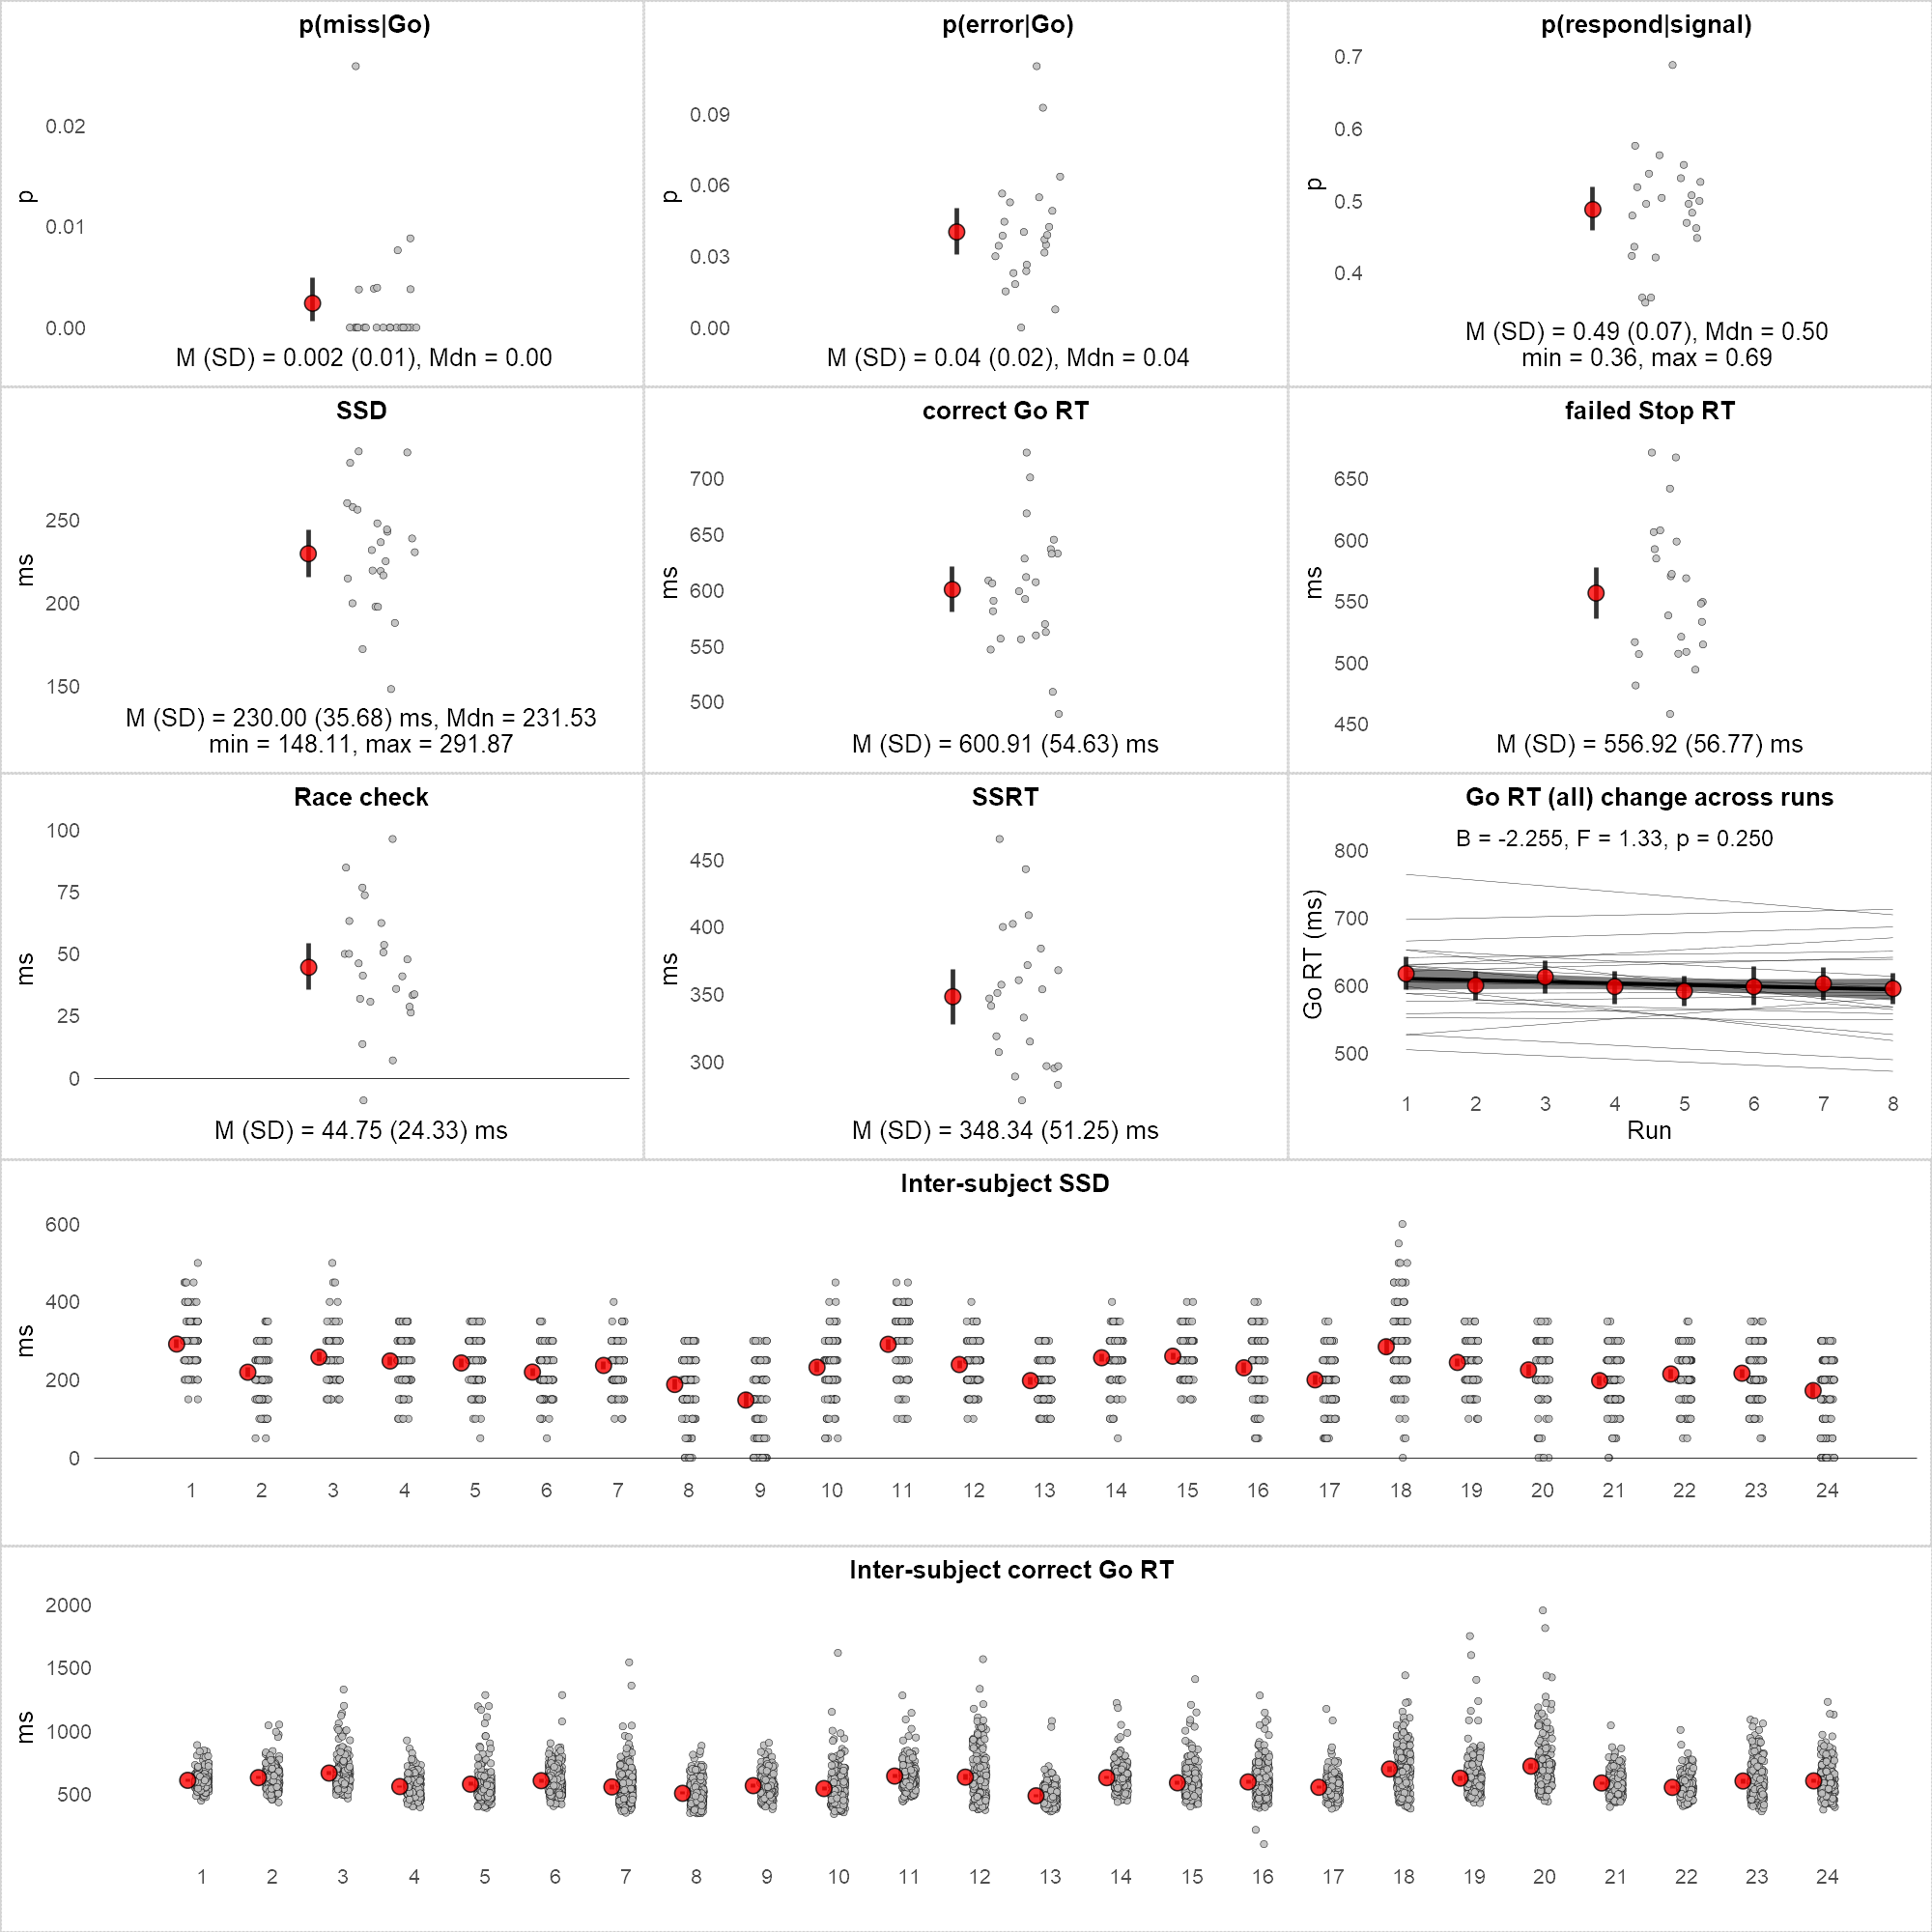

In [7]:
# Plot results
# ----------------------------------------------------------------------
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200) 

# 1. Probability of Go omissions (no response)
p1 <- plotResults(dataSSTsubj, dataSSTsubj$pmiss, 1, "p(miss|Go)", "p", 
                   sprintf("M (SD) = %.3f (%.2f), Mdn = %.2f", 
                           dscrSST["mean","pmiss"], dscrSST["std.dev","pmiss"], dscrSST["median","pmiss"])) + 
      scale_x_discrete()

# 2. Probability of choice errors on Go trials
p2 <- plotResults(dataSSTsubj, dataSSTsubj$perror, 1, "p(error|Go)", "p",
                   sprintf("M (SD) = %.2f (%.2f), Mdn = %.2f", 
                           dscrSST["mean","perror"], dscrSST["std.dev","perror"], dscrSST["median","perror"])) + 
      scale_x_discrete()

# 3. Probability of responding on a Stop trial
# recommended to refrain from estimating individual SSRTs when p (respond|signal) 
# is lower than 0.25 or higher than 0.75
p3 <- plotResults(dataSSTsubj, dataSSTsubj$presp, 1, "p(respond|signal)", "p",
                    sprintf("M (SD) = %.2f (%.2f), Mdn = %.2f\nmin = %.2f, max = %.2f", 
                            dscrSST["mean","presp"], dscrSST["std.dev","presp"], dscrSST["median","presp"], 
                            dscrSST["min","presp"], dscrSST["max","presp"])) + 
      scale_x_discrete()

# 4. Average Stop-Signal Delay
p4 <- plotResults(dataSSTsubj, dataSSTsubj$SSD, 1, "SSD", "ms",
                    sprintf("M (SD) = %.2f (%.2f) ms, Mdn = %.2f\nmin = %.2f, max = %.2f", 
                            dscrSST["mean","SSD"], dscrSST["std.dev","SSD"], dscrSST["median","SSD"], 
                            dscrSST["min","SSD"], dscrSST["max","SSD"])) + 
      scale_x_discrete()

# 5. Mean RT on correct Go trials
p5 <- plotResults(dataSSTsubj, dataSSTsubj$goRTcorr, 1, "correct Go RT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","goRTcorr"], dscrSST["std.dev","goRTcorr"])) + 
      scale_x_discrete()

# 6. RT of unsuccessful Stop trials 
p6 <- plotResults(dataSSTsubj, dataSSTsubj$sRT, 1, "failed Stop RT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","sRT"], dscrSST["std.dev","sRT"])) + 
      scale_x_discrete()

# 7. Race Check (with correct Go)
p7 <- plotResults(dataSSTsubj, dataSSTsubj$raceCheck, 1, "Race check", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","raceCheck"], dscrSST["std.dev","raceCheck"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 8. Stop-signal reaction time (SSRT)
# integration method (with replacement of Go omissions) when
p8 <- plotResults(dataSSTsubj, dataSSTsubj$SSRT, 1, "SSRT", "ms",
                   sprintf("M (SD) = %.2f (%.2f) ms", 
                           dscrSST["mean","SSRT"], dscrSST["std.dev","SSRT"])) + 
      scale_x_discrete()

# 9. Change in Go RT across runs
dataSSTsubjRun <- ddply(dataSST, .(sNR, run), funcSignal)

p9.res.lm  <- summary(lm(goRTall ~ run, data = dataSSTsubjRun))
p9.res.aov <- unlist(summary(aov(goRTall ~ run, data = dataSSTsubjRun)))
p9.rxt <- sprintf('B = %.3f, F = %.2f, p = %.3f',
        p9.res.lm$coefficients["run", "Estimate"],
        p9.res.aov["F value1"],
        p9.res.lm$coefficients["run", "Pr(>|t|)"])

p9 <- ggplot(dataSSTsubjRun, aes(x = run, y = goRTall)) +
  # subject lines
  geom_smooth(method = lm, formula = y ~ x, se = FALSE, color = "black", size = 0.05) + aes(fill = factor(sNR)) + 
  # group line
  geom_smooth(colour = "black", method = lm, formula = y ~ x, size = 0.5, alpha = .5, fill = "black") +
  # run means
  stat_summary(fun.data = mean_cl_boot, geom = "pointrange", fill = 'red', alpha = 0.8,
               color = "black", size = 0.6, stroke = 0.3, shape = 21) + 
  labs(x = "Run", y = "Go RT (ms)") + ggtitle("Go RT (all) change across runs") +
  scale_x_continuous(breaks = unique(dataSSTsubjRun$run)) +
  annotate("text", label= p9.rxt, x = 4, y = max(dataSSTsubjRun$goRTall), size = 3) +
  theme_minimal() +
  theme(text = element_text(size = 9), 
        plot.title = element_text(hjust = 0.5, size = 9, face="bold"), 
        plot.background = element_rect(color = "lightgrey", size = 0.4, linetype = "dotted"), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(), legend.position="none")

# 10. Inter-subject variability of SSD
dataSignal <- subset(dataSST, gkind == '1')
p10 <- plotResults(dataSignal, dataSignal$gintVal, dataSignal$sNR, "Inter-subject SSD", "ms", "") + 
  geom_hline(aes(yintercept = 0), size = 0.1) + scale_x_continuous(breaks = unique(dataSignal$sNR))

# 11. Inter-subject variability of RT on correct Go trials
#options(repr.plot.width = 8, repr.plot.height = 3)
dataNoSignal <- subset(dataSST, gkind == '0' & gRT != '0')
dataNoSignal$error <- ifelse(dataNoSignal$gtheButton == dataNoSignal$gresp, 0, 1)
dataNoSignalCorr <- subset(dataNoSignal, error == '0')
dataNoSignalCorr.rt <- mean(dataNoSignalCorr$gRT)
p11 <- plotResults(dataNoSignalCorr, dataNoSignalCorr$gRT, dataNoSignalCorr$sNR, 
                   "Inter-subject correct Go RT", "ms", "") + 
   scale_x_continuous(breaks = unique(dataSignal$sNR))

## Put all plots in a grid and display
ly1 <- rbind(c(1,2,3),c(4,5,6), c(7,8,9), c(10,10,10), c(11,11,11))
grid.arrange(p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, layout_matrix = ly1)

## Think/No-Think task performance

### Summary data and decriptives

In [8]:
# ==================================================================
# TNT RESULTS
# ==================================================================
# display
# sp - Same probe test
# ip - Independent probe test
# uc - unconditionalised
# c  - conditionalised
print(cbind(dataTNT[, 4:10], round(dataTNT[, 11:ncol(dataTNT)], 0)))

   cgroup testorder    sex age items learned criterion spTuc spNTuc spBuc
1       A      IPSP Female  19    60      49        82   100     95    95
2       B      IPSP Female  22    60      35        58    80     40    60
3       B      SPIP   Male  25    60      51        85   100     95   100
4       C      IPSP   Male  26    60      51        85    95     90    90
5       C      SPIP Female  22    60      54        90    80     85    90
6       A      SPIP Female  28    60      34        57    80     70    50
7       A      IPSP Female  24    60      57        95    95     95    85
8       B      IPSP Female  25    60      39        65    80     60    80
9       A      SPIP Female  36    60      38        63    75     80    65
10      A      IPSP Female  24    60      58        97   100     85   100
11      B      SPIP   Male  35    60      25        42    45     35    50
12      B      SPIP Female  21    60      25        42    40     25    55
13      B      IPSP Female  22    60  

In [9]:
# Descriptives
# ----------------------------------------------------------------------
dscrTNT <- stat.desc(dataTNT[, 7:ncol(dataTNT)], basic = TRUE, desc = TRUE, p = 0.95)
print(round(dscrTNT, 0))

             age items learned criterion spTuc spNTuc spBuc spSIFuc ipTuc
nbr.val       24    24      24        24    24     24    24      24    24
nbr.null       0     0       0         0     0      1     0       6     0
nbr.na         0     0       0         0     0      0     0       0     0
min           19    60      25        42    35      0    35     -20    25
max           36    60      58        97   100    100   100      60    70
range         17     0      33        55    65    100    65      80    45
sum          592  1440    1028      1713  1885   1670  1810     140  1240
median        24    60      44        74    80     82    80       2    55
mean          25    60      43        71    79     70    75       6    52
SE.mean        1     0       2         3     4      5     4       3     3
CI.mean.0.95   2     0       4         7     8     11     8       7     6
var           19     0     104       290   390    715   382     269   180
std.dev        4     0      10        

### Result plots

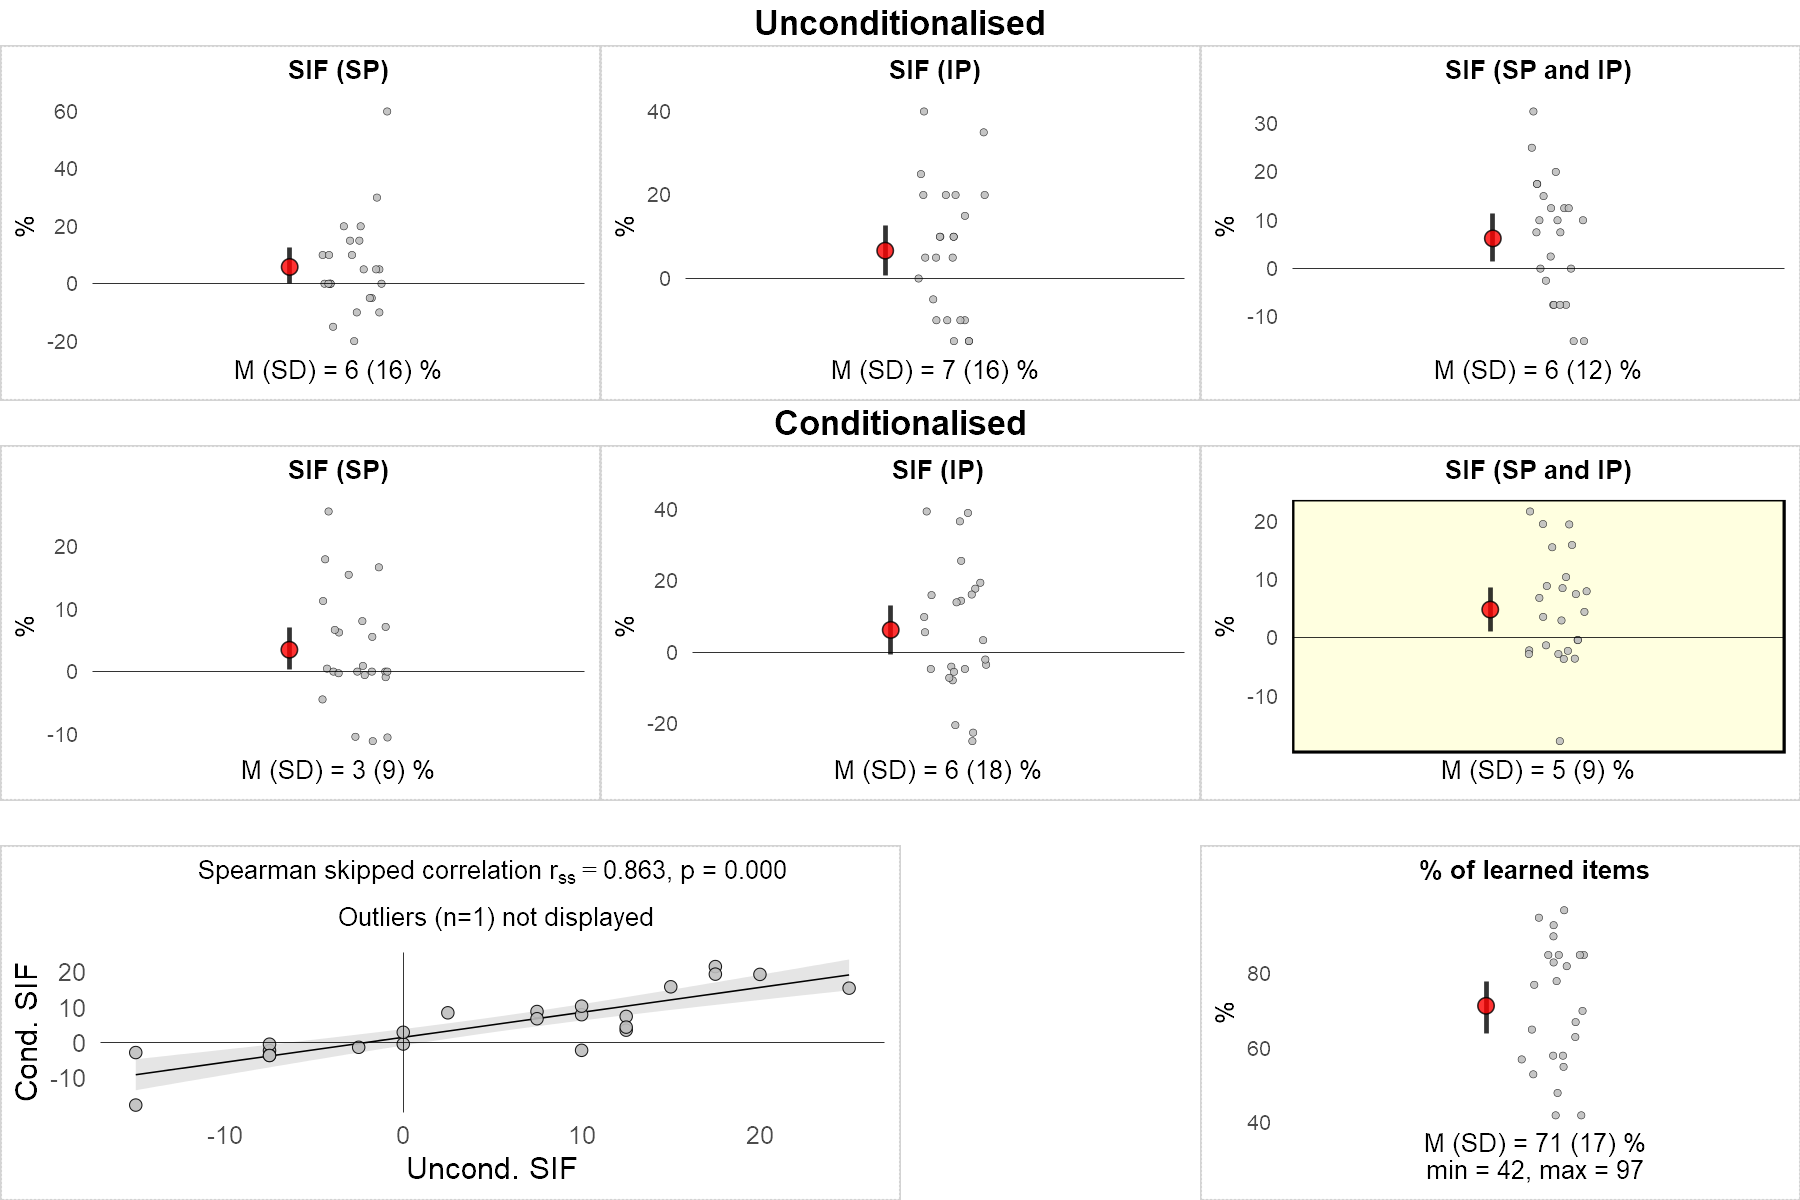

In [52]:
# Plot results
# ----------------------------------------------------------------------
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 200) 

# 1. Unconditionalised SP SIF
p12 <- plotResults(dataTNT, dataTNT$spSIFuc, 1, "SIF (SP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spSIFuc"], dscrTNT["std.dev","spSIFuc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 2. Unconditionalised IP SIF
p13 <- plotResults(dataTNT, dataTNT$ipSIFuc, 1, "SIF (IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","ipSIFuc"], dscrTNT["std.dev","ipSIFuc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 3. Unconditionalised SPIP SIF SP and IP
p14 <- plotResults(dataTNT, dataTNT$spipSIFuc, 1, "SIF (SP and IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spipSIFuc"], dscrTNT["std.dev","spipSIFuc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 4. Conditionalised SP SIF
p15 <- plotResults(dataTNT, dataTNT$spSIFc, 1, "SIF (SP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spSIFc"], dscrTNT["std.dev","spSIFc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 5. Conditionalised IP SIF
p16 <- plotResults(dataTNT, dataTNT$ipSIFc, 1, "SIF (IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","ipSIFc"], dscrTNT["std.dev","ipSIFc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1)

# 6. Conditionalised SIF SP and IP
p17 <- plotResults(dataTNT, dataTNT$spipSIFc, 1, "SIF (SP and IP)", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%", 
                           dscrTNT["mean","spipSIFc"], dscrTNT["std.dev","spipSIFc"])) + 
      scale_x_discrete() + geom_hline(aes(yintercept = 0), size = 0.1) + theme(
  panel.background = element_rect(fill = "lightyellow"))

# 7. Relationship between conditionalised and unconditionalised SIFs
outliers <- get_outliers(dataTNT$spipSIFuc, "unc. SIF", "%", dataTNT$spipSIFc, "cond. SIF", "", disp = FALSE)
corRes <- doCorrelation(dataTNT$spipSIFuc, dataTNT$spipSIFc, outliers)
p18 <- plotCorrelation(dataTNT$spipSIFuc, dataTNT$spipSIFc,"Uncond. SIF","Cond. SIF",corRes, 1.8, 11, outliers) + 
            geom_vline(aes(xintercept = 0), size = 0.1) + geom_hline(aes(yintercept = 0), size = 0.1)

# 8. % of learned (included in analysis) items
p19 <- plotResults(dataTNT, dataTNT$criterion, 1, "% of learned items", "%",
                   sprintf("M (SD) = %.0f (%.0f) %%\nmin = %.0f, max = %.0f", 
                           dscrTNT["mean","criterion"], dscrTNT["std.dev","criterion"], 
                           dscrTNT["min","criterion"], dscrTNT["max","criterion"])) + 
      scale_x_discrete()

## Put all plots in a grid and display
grid.arrange(arrangeGrob(p12, p13, p14, 
                         top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), nrow = 1), 
             arrangeGrob(p15, p16, p17, 
                         top = textGrob("Conditionalised", gp=gpar(fontface="bold")), nrow = 1),
             arrangeGrob(p18, p19, 
                         top="", layout_matrix = rbind(c(1,1,1,NA,2,2))))

### SIF effect (conditionalised, SP and IP)

In [11]:
# SIF effect (conditionalised, SP and IP)
# ----------------------------------------------------------------------
# http://www.sthda.com/english/wiki/one-sample-t-test-in-r
# Since the sample size is not large enough (less than 30, central limit theorem), we need to check whether 
# the data follow a normal distribution.
# It's possible to use the Shapiro-Wilk normality test and to look at the normality plot.
# 
# Shapiro-Wilk test:
#   Null hypothesis: the data are normally distributed
# Alternative hypothesis: the data are not normally distributed
shapiro.test(dataTNT$spipSIFc)

# SIF data are normally  distributed! Can do t.test. Otherwise would need to to wilcox.test
t.SIFc <- t.test(dataTNT$spipSIFc, mu = 0, alternative = "greater")
t.SIFc
sprintf("SIF effect: t(%d) = %.2f, p = %.3f, d = %.3f", 
        t.SIFc$parameter, t.SIFc$statistic, t.SIFc$p.value, t.SIFc$statistic/sqrt(t.SIFc$parameter+1))



	Shapiro-Wilk normality test

data:  dataTNT$spipSIFc
W = 0.94945, p-value = 0.2636



	One Sample t-test

data:  dataTNT$spipSIFc
t = 2.5519, df = 23, p-value = 0.008912
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 1.592493      Inf
sample estimates:
mean of x 
 4.849436 


[1] "SIF effect: t(23) = 2.55, p = 0.009, d = 0.521"

## SSRT and SIF outliers
To identify univariate and bi-variate outliers in the SSRT and SIF scores, we used box plot method, which relies on the interquartile range. Univariate outliers were not present for any of the two measures. One bi-variate outlier was removed from the correlation analysis and the behavioural partial least squares analysis (described below). Nevertheless, outlier removal did not qualitatively alter the results.

In [12]:
# ==================================================================
# SSRT and SIF OUTLIERS
# ==================================================================
SSRT <- dataSSTsubj$SSRT
SIF  <- dataTNT$spSIFc

### Outliers with Unconditionalised SIF

[1] "SP&IP outliers: 0"
numeric(0)
[1] "SSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


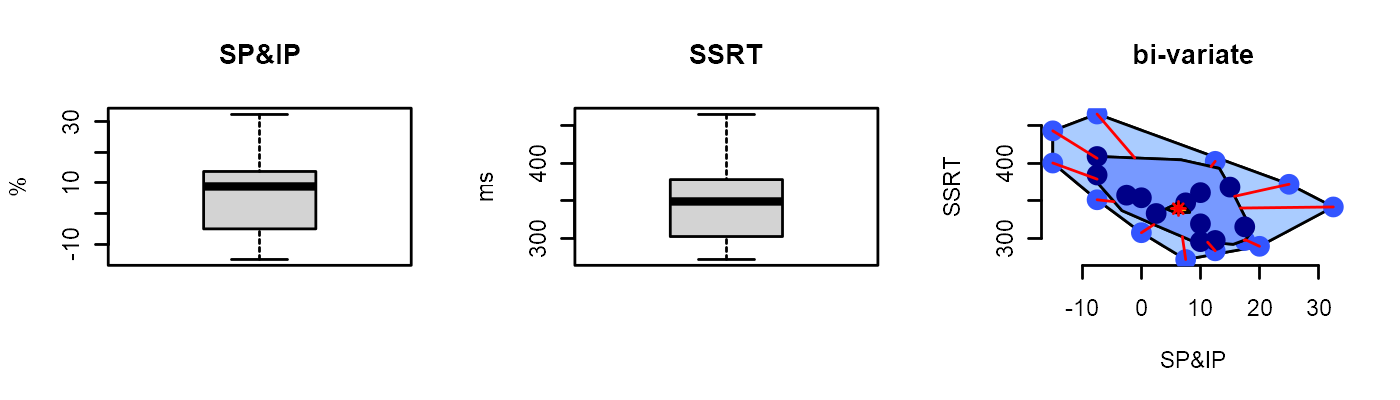

[1] "SP outliers: 1"
[1] 16
[1] "SSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 1"
[1] 16


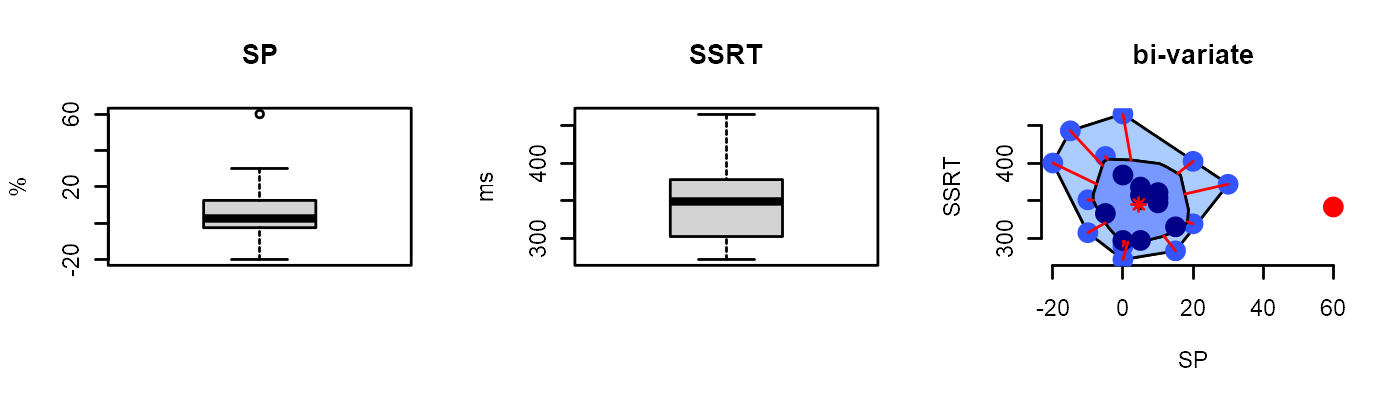

[1] "IP outliers: 0"
numeric(0)
[1] "SSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


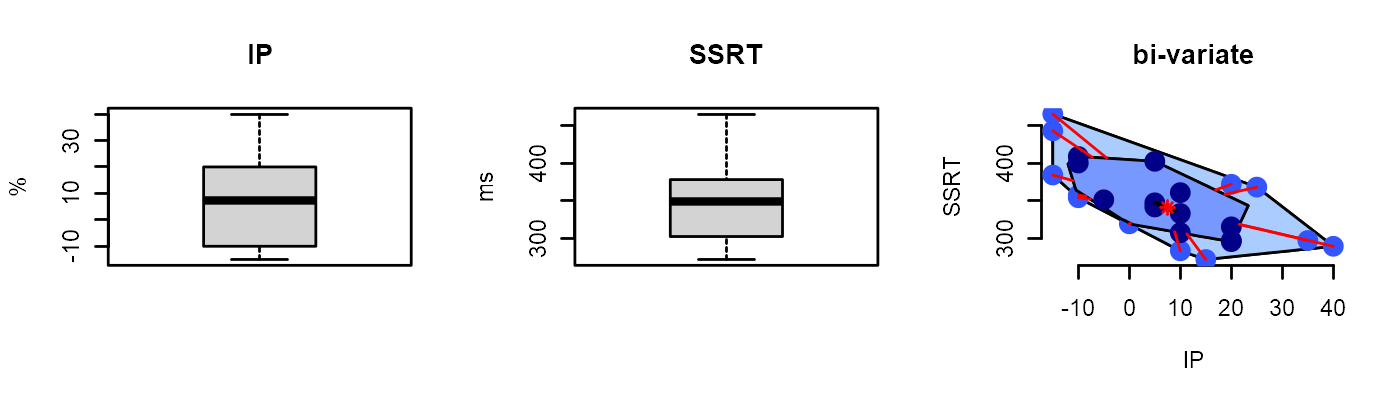

In [13]:
options(repr.plot.width = 7, repr.plot.height = 2, repr.plot.res = 200) # change plot size
u_spipOutliers <- get_outliers(dataTNT$spipSIFu, "SP&IP", "%", SSRT, "SSRT", "ms", disp = TRUE)
u_spOutliers   <- get_outliers(dataTNT$spSIFu, "SP", "%", SSRT, "SSRT", "ms", disp = TRUE)
u_ipOutliers   <- get_outliers(dataTNT$ipSIFu, "IP", "%", SSRT, "SSRT", "ms", disp = TRUE)

### Outliers with Conditionalised SIF

[1] "SP&IP outliers: 0"
numeric(0)
[1] "SSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 1"
[1] 9


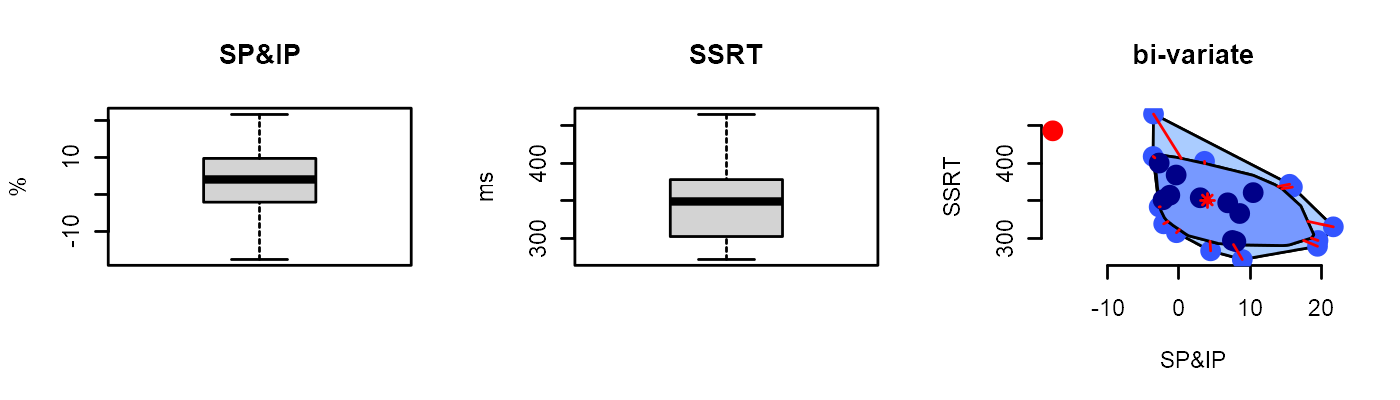

[1] "SP outliers: 1"
[1] 23
[1] "SSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


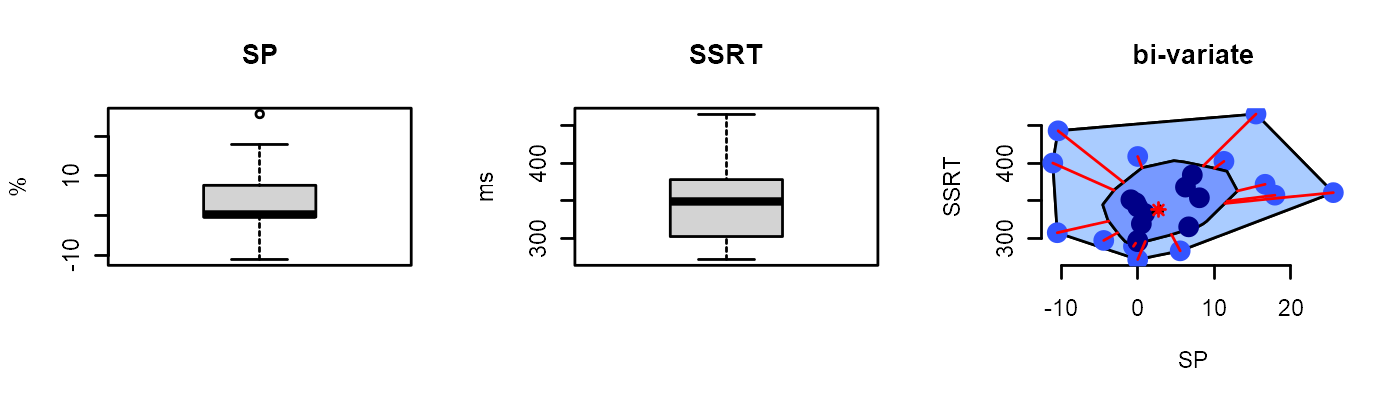

[1] "IP outliers: 0"
numeric(0)
[1] "SSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


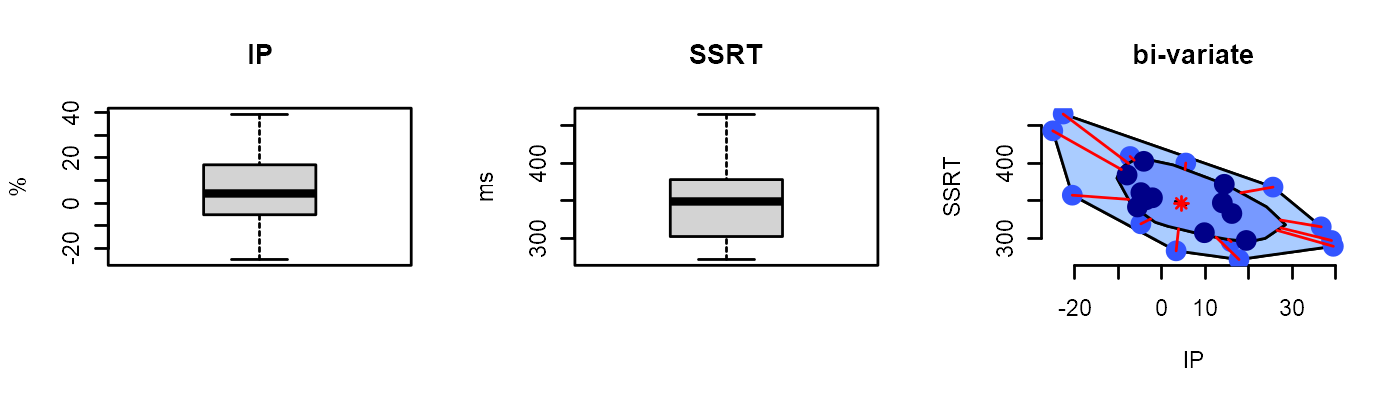

In [14]:
options(repr.plot.width = 7, repr.plot.height = 2, repr.plot.res = 200) # change plot size
c_spipOutliers <- get_outliers(dataTNT$spipSIFc, "SP&IP", "%", SSRT, "SSRT", "ms", disp = TRUE)
c_spOutliers   <- get_outliers(dataTNT$spSIFc, "SP", "%", SSRT, "SSRT", "ms", disp = TRUE)
c_ipOutliers   <- get_outliers(dataTNT$ipSIFc, "IP", "%", SSRT, "SSRT", "ms", disp = TRUE)

## SSRT and SIF correlation

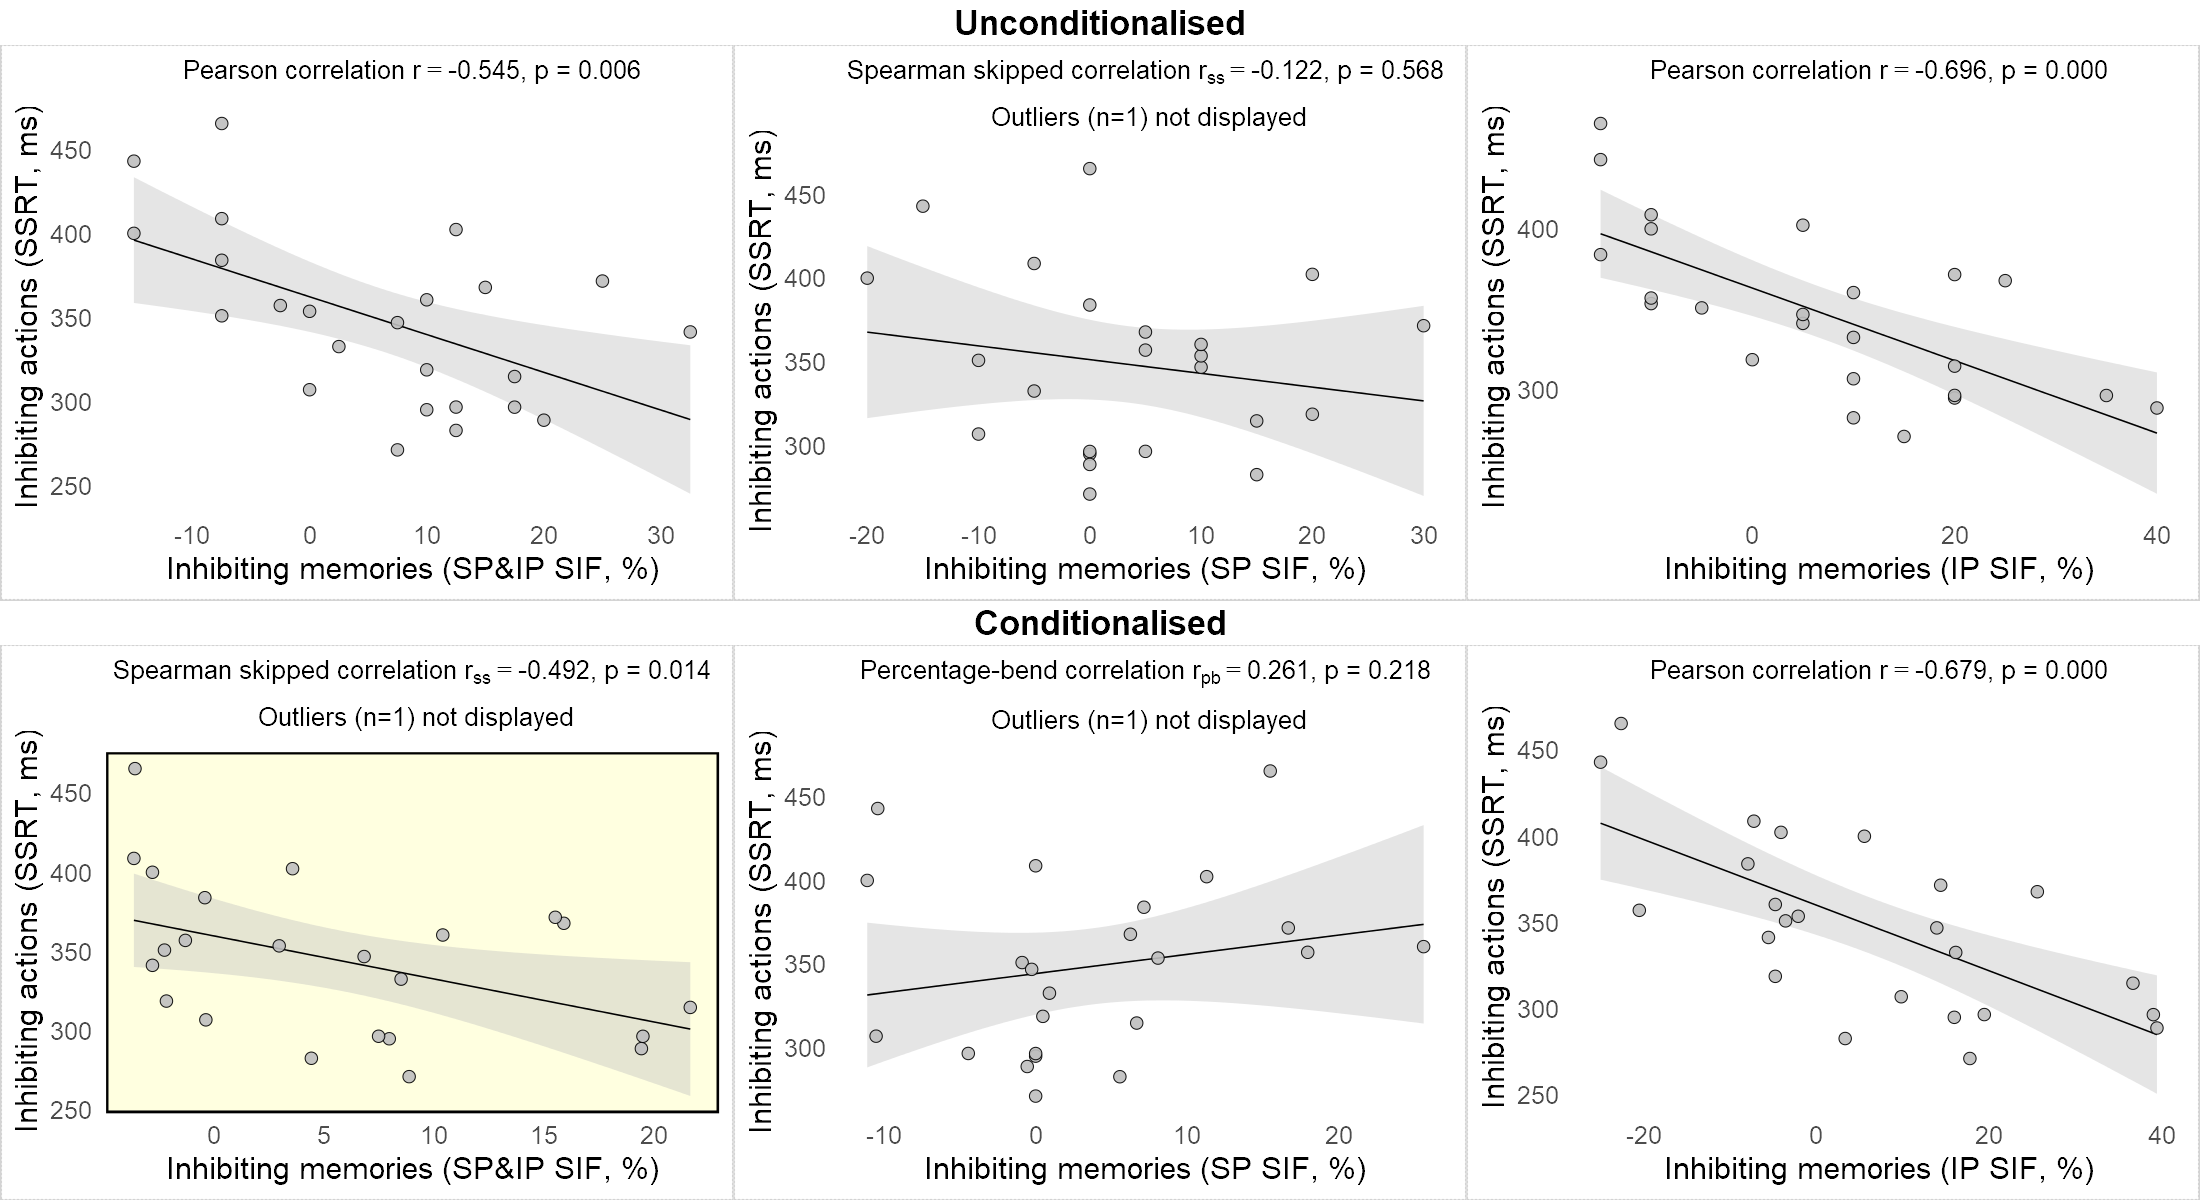

In [15]:
options(repr.plot.width = 11, repr.plot.height = 6, repr.plot.res = 200) # change plot size
grid.arrange(
  arrangeGrob(
    plotCorrelation(dataTNT$spipSIFu,SSRT,"Inhibiting memories (SP&IP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$spipSIFu, SSRT, u_spipOutliers),
                    1.8, 11, u_spipOutliers), 
    plotCorrelation(dataTNT$spSIFu,SSRT,"Inhibiting memories (SP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$spSIFu, SSRT, u_spOutliers),
                    1.8, 11, u_spOutliers), 
    plotCorrelation(dataTNT$ipSIFu,SSRT,"Inhibiting memories (IP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$ipSIFu, SSRT, u_ipOutliers),
                    1.8, 11, u_ipOutliers), 
    top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), 
    nrow = 1),
  
  arrangeGrob(
    plotCorrelation(dataTNT$spipSIFc,SSRT,"Inhibiting memories (SP&IP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$spipSIFc, SSRT, c_spipOutliers),
                    1.8, 11, c_spipOutliers) + theme(panel.background = element_rect(fill = "lightyellow")), 
    plotCorrelation(dataTNT$spSIFc,SSRT,"Inhibiting memories (SP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$spSIFc, SSRT, c_spOutliers),
                    1.8, 11, u_spOutliers), 
    plotCorrelation(dataTNT$ipSIFc,SSRT,"Inhibiting memories (IP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$ipSIFc, SSRT, c_ipOutliers),
                    1.8, 11, u_ipOutliers),
    top = textGrob("Conditionalised", gp=gpar(fontface="bold")), 
    nrow = 1)
)

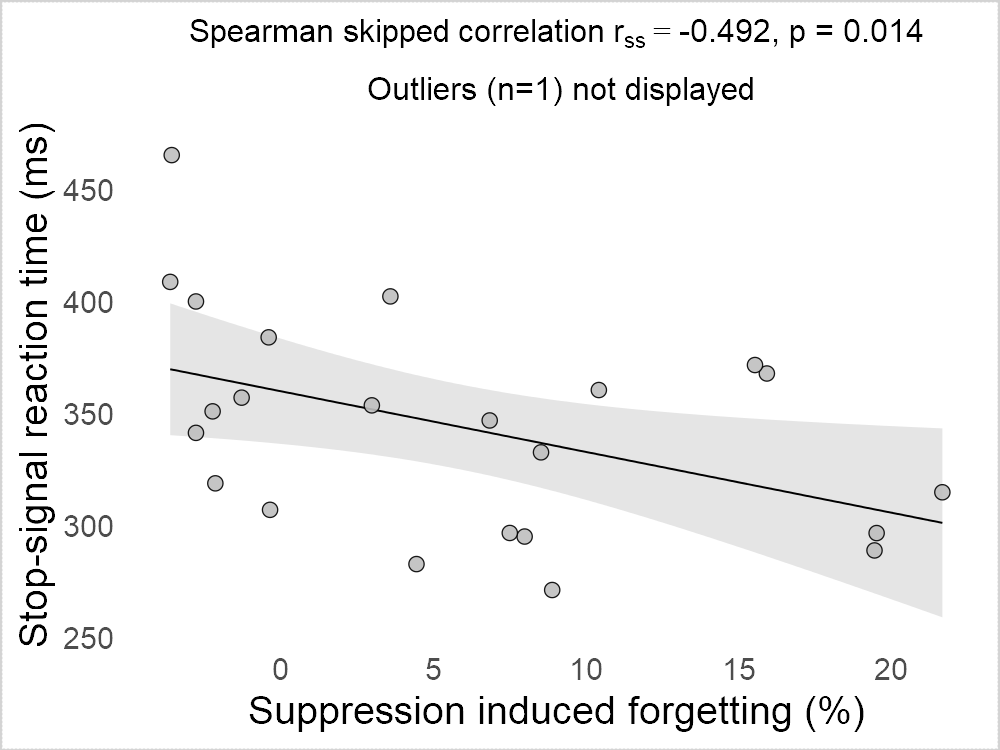

In [16]:
options(repr.plot.width = 4, repr.plot.height = 3, repr.plot.res = 250) 
plotCorrelation(dataTNT$spipSIFc,SSRT,"Suppression induced forgetting (%)","Stop-signal reaction time (ms)",
                    doCorrelation(dataTNT$spipSIFc, SSRT, c_spipOutliers),
                    1.8, 11, c_spipOutliers)

## SSRTs accounting for Stop Trigger Failures

In [17]:
# ==================================================================
# SSRT with Trigger Failures
# ==================================================================
# Descriptives
# ----------------------------------------------------------------------
dscr_tfSSRT <-
  stat.desc(data_tfSSRT,
            basic = TRUE,
            desc = TRUE,
            p = 0.95)
print(round(dscr_tfSSRT, 2))

tfSSRT <- data_tfSSRT$tfSSRT
tf     <- data_tfSSRT$p_tf

                sID  tfSSRT  p_tf
nbr.val       24.00   24.00 24.00
nbr.null       0.00    0.00  0.00
nbr.na         0.00    0.00  0.00
min            1.00  208.82  0.12
max           24.00  341.18  0.46
range         23.00  132.35  0.34
sum          300.00 6692.16  6.06
median        12.50  279.01  0.24
mean          12.50  278.84  0.25
SE.mean        1.44    8.40  0.02
CI.mean.0.95   2.99   17.37  0.04
var           50.00 1691.84  0.01
std.dev        7.07   41.13  0.09
coef.var       0.57    0.15  0.34


### Outliers
#### Outliers with Unconditionalised SIF

[1] "SP&IP outliers: 0"
numeric(0)
[1] "tfSSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


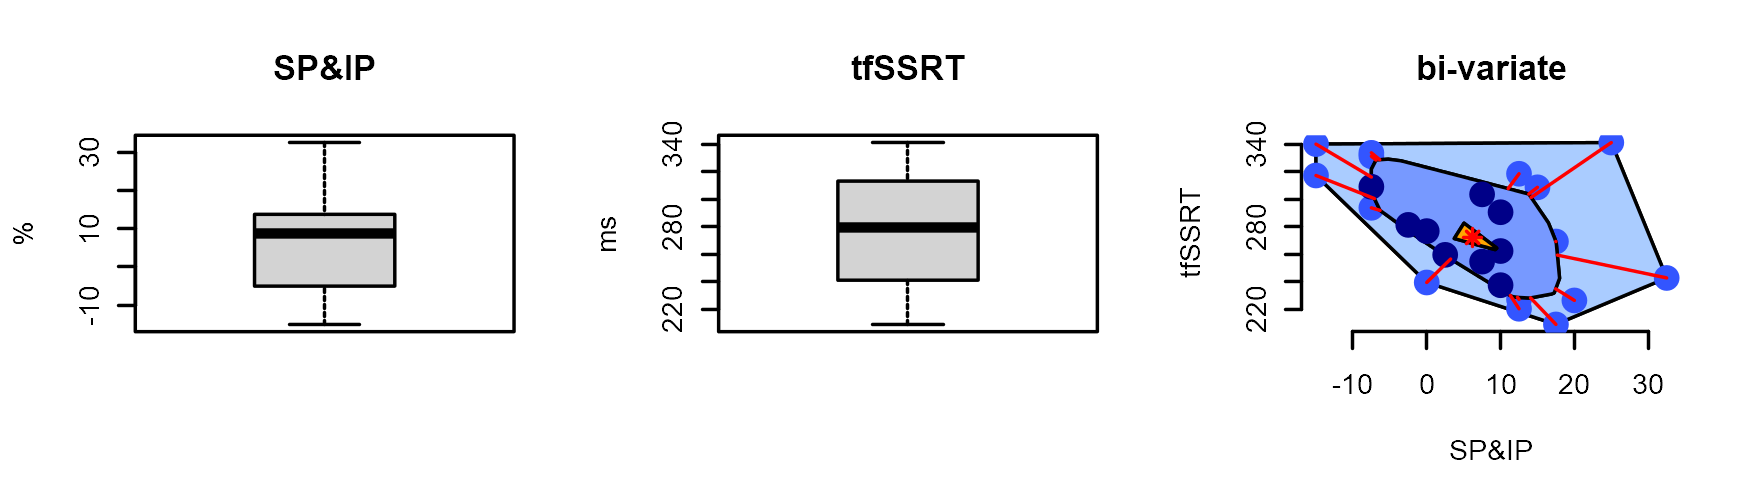

[1] "SP outliers: 1"
[1] 16
[1] "tfSSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 1"
[1] 16


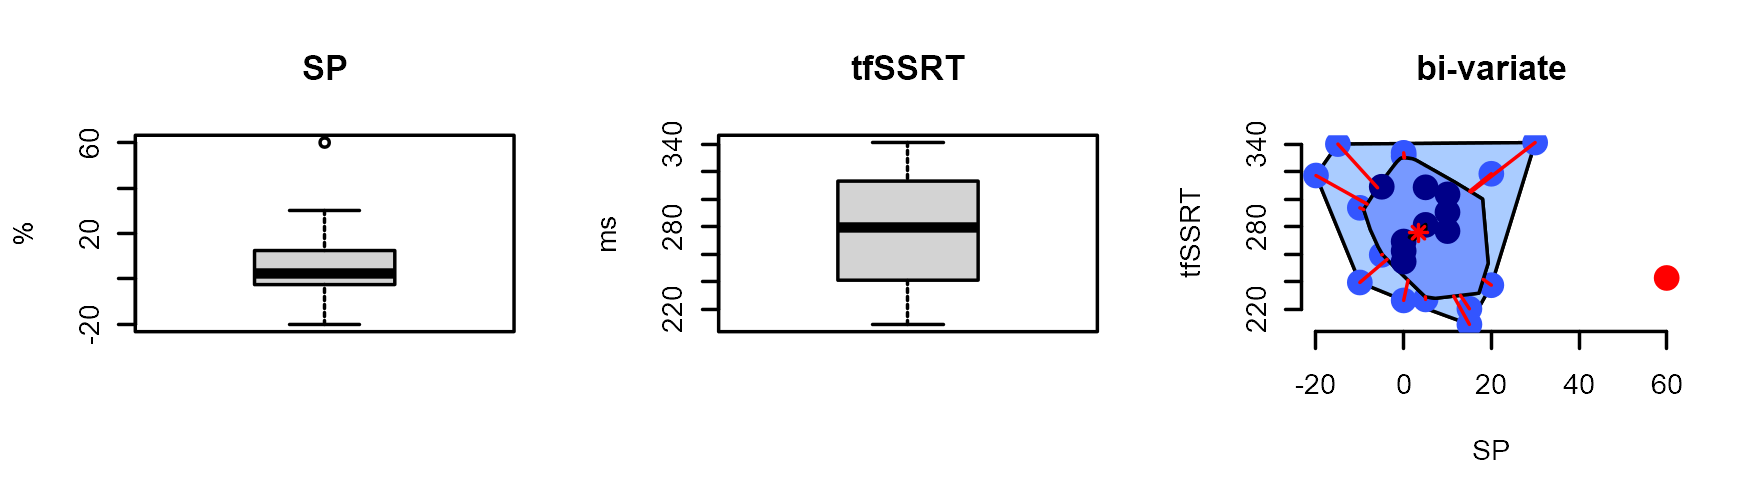

[1] "IP outliers: 0"
numeric(0)
[1] "tfSSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


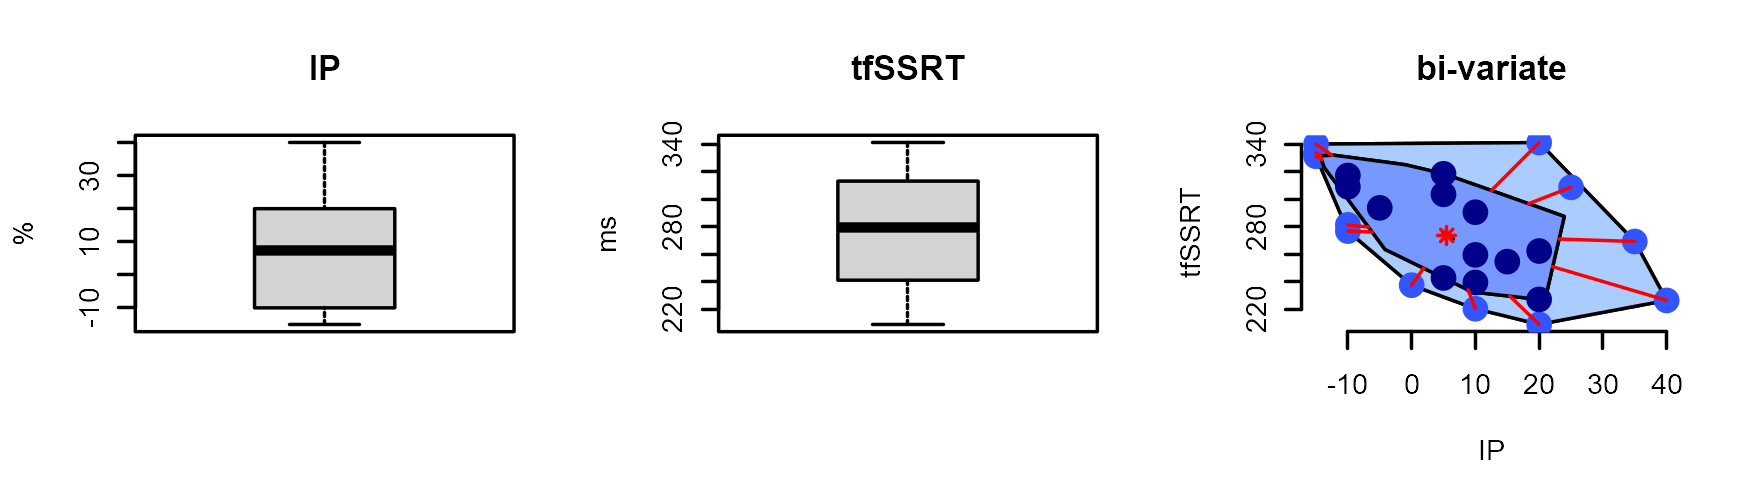

In [18]:
options(repr.plot.width = 7, repr.plot.height = 2) # change plot size
u_spipOutl_tfSSRT <- get_outliers(dataTNT$spipSIFu, "SP&IP", "%", tfSSRT, "tfSSRT", "ms", disp = TRUE)
u_spOutl_tfSSRT   <- get_outliers(dataTNT$spSIFu, "SP", "%", tfSSRT, "tfSSRT", "ms", disp = TRUE)
u_ipOutl_tfSSRT   <- get_outliers(dataTNT$ipSIFu, "IP", "%", tfSSRT, "tfSSRT", "ms", disp = TRUE)

#### Outliers with Conditionalised SIF

[1] "SP&IP outliers: 0"
numeric(0)
[1] "tfSSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


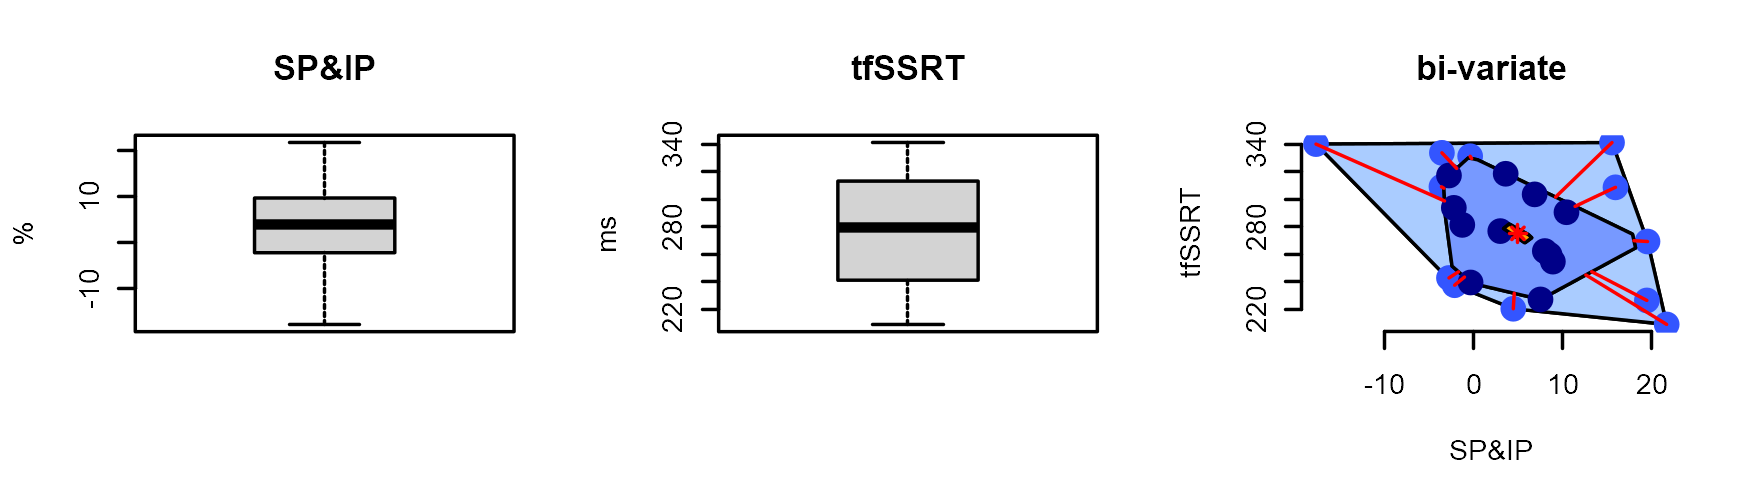

[1] "SP outliers: 1"
[1] 23
[1] "tfSSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 2"
[1] 6 9


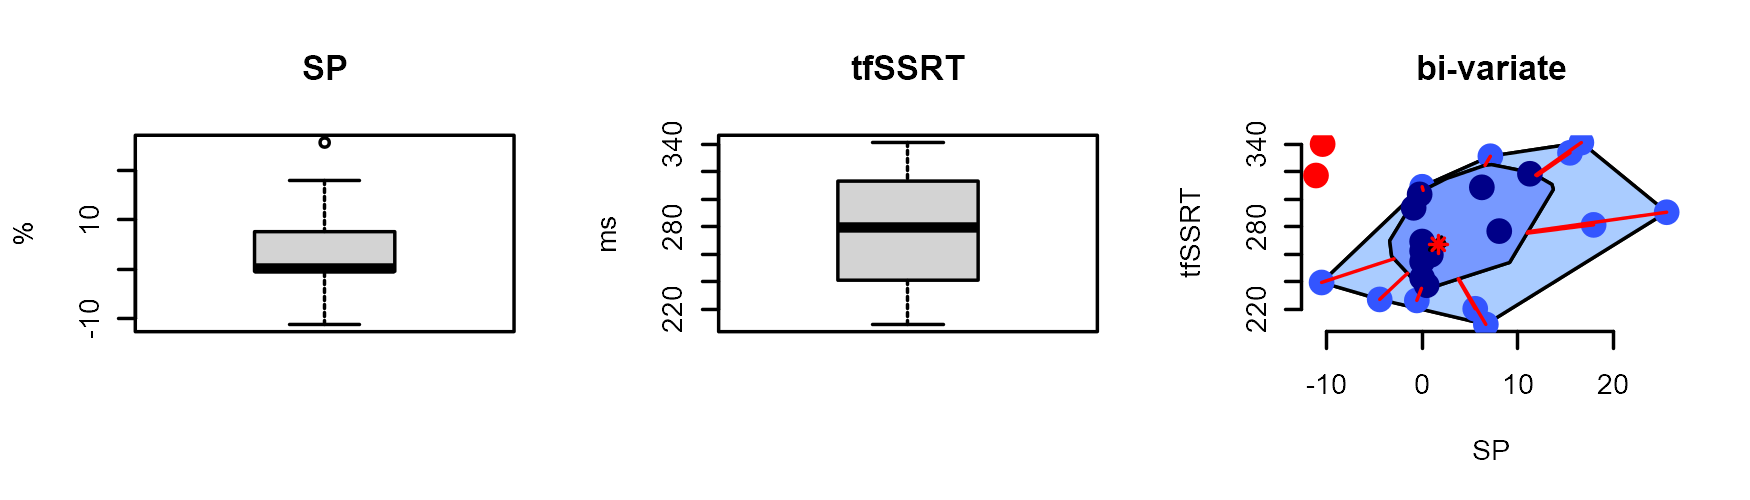

[1] "IP outliers: 0"
numeric(0)
[1] "tfSSRT outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


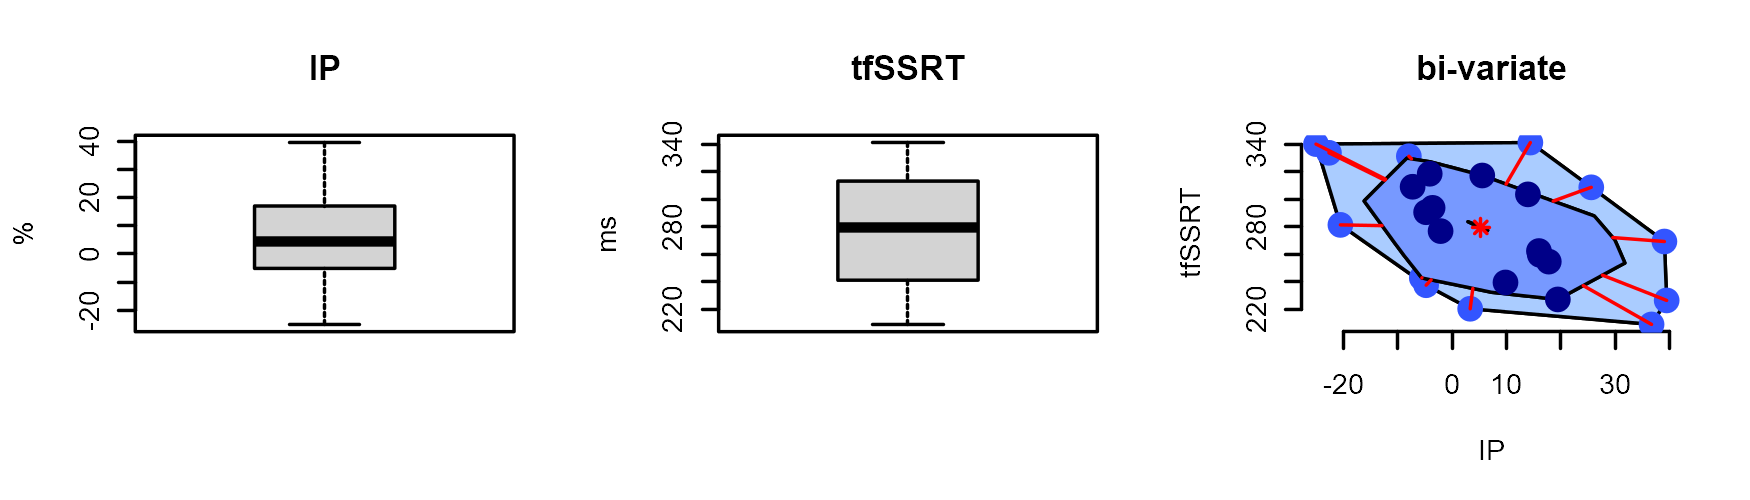

In [19]:
options(repr.plot.width = 7, repr.plot.height = 2) # change plot size
c_spipOutl_tfSSRT <- get_outliers(dataTNT$spipSIFc, "SP&IP", "%", tfSSRT, "tfSSRT", "ms", disp = TRUE)
c_spOutl_tfSSRT   <- get_outliers(dataTNT$spSIFc, "SP", "%", tfSSRT, "tfSSRT", "ms", disp = TRUE)
c_ipOutl_tfSSRT   <- get_outliers(dataTNT$ipSIFc, "IP", "%", tfSSRT, "tfSSRT", "ms", disp = TRUE)

### tfSSRT and SIF correlation

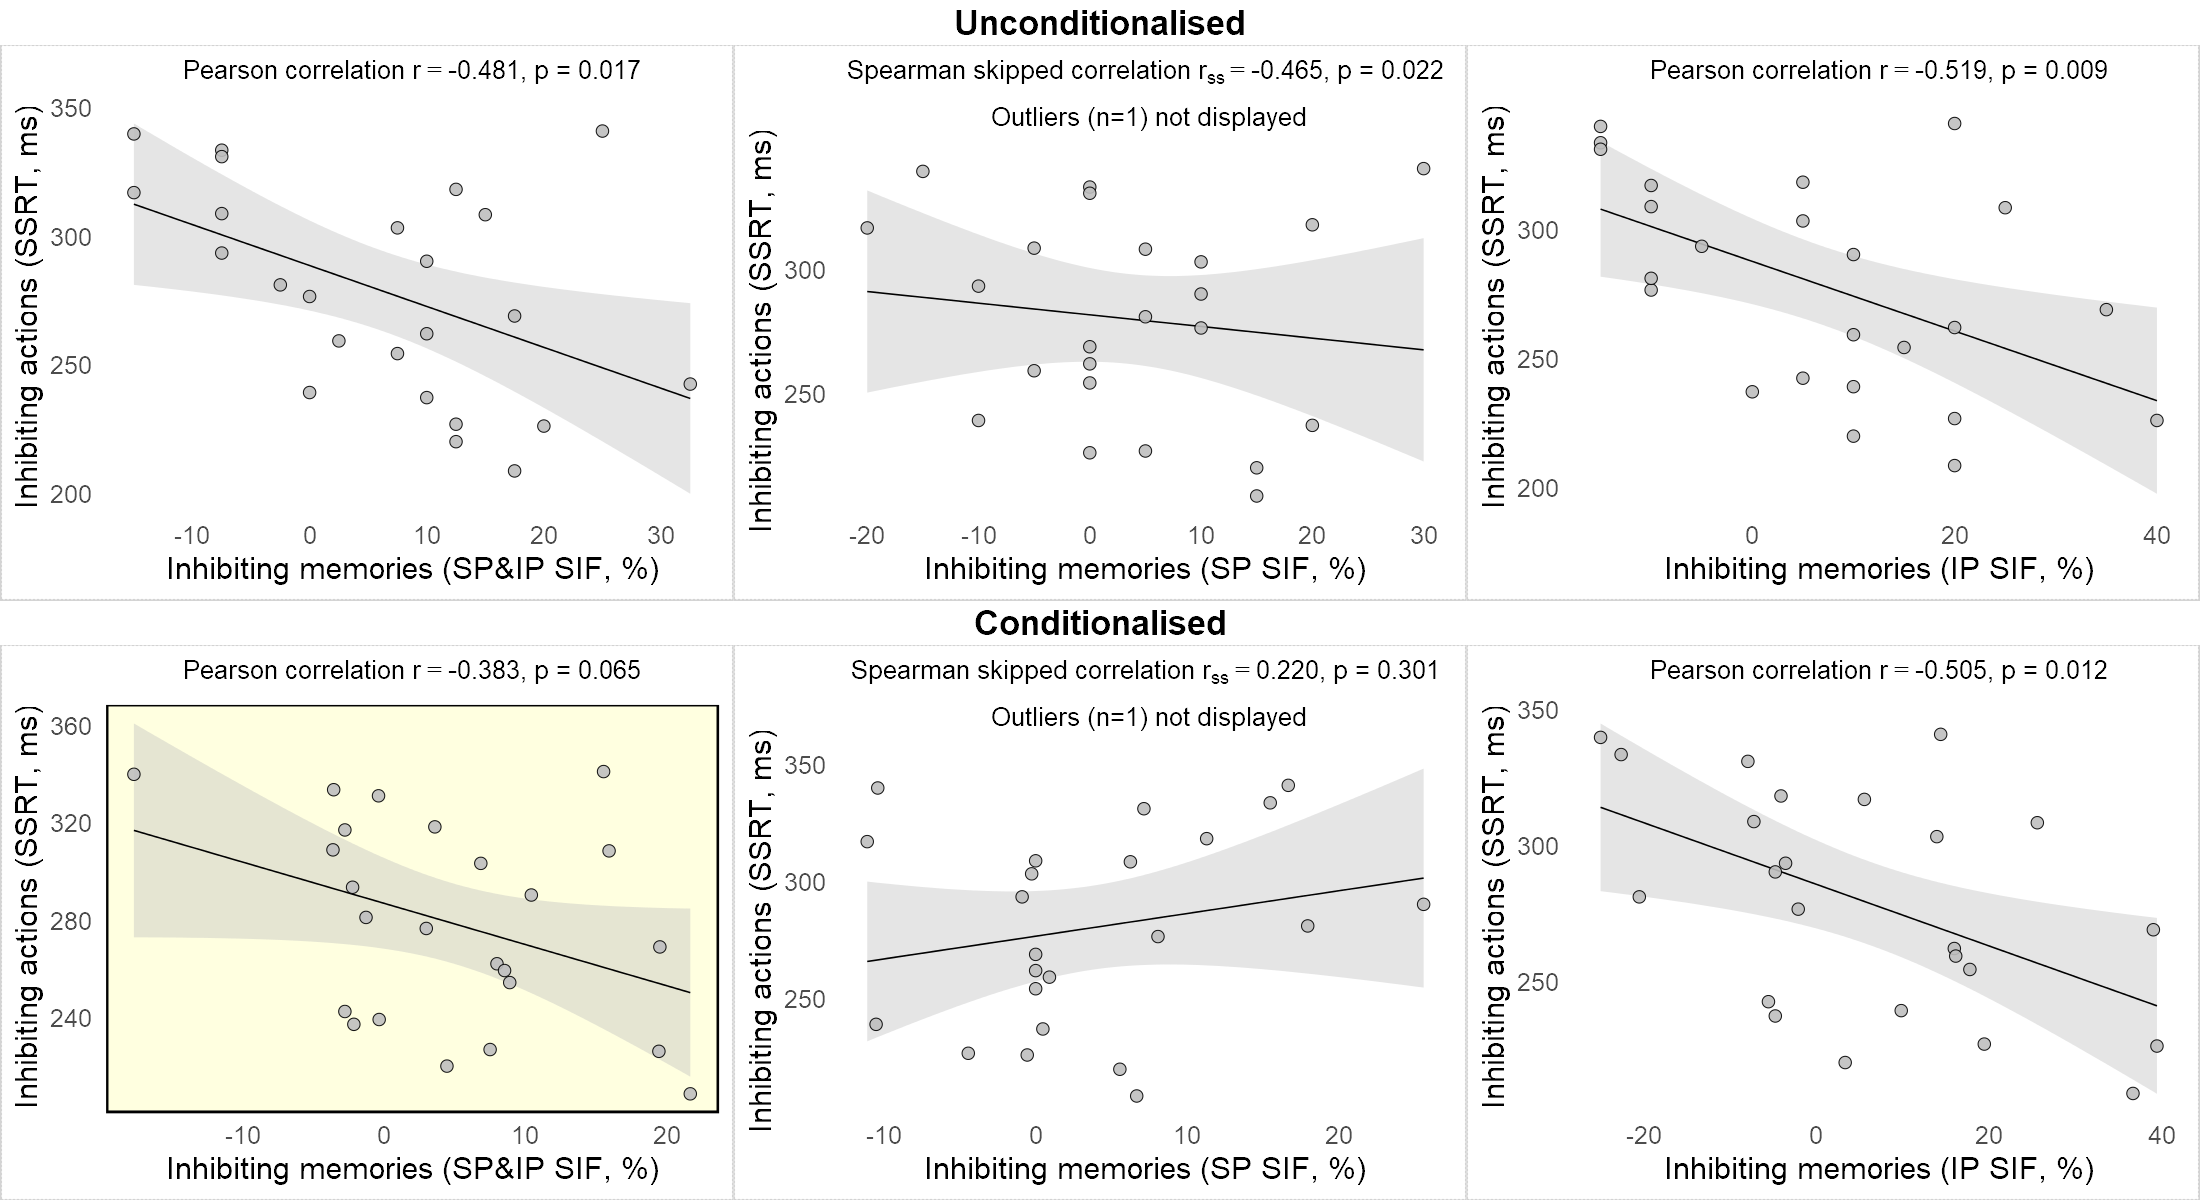

In [20]:
options(repr.plot.width = 11, repr.plot.height = 6, repr.plot.res = 200) # change plot size
grid.arrange(
  arrangeGrob(
    plotCorrelation(dataTNT$spipSIFu,tfSSRT,"Inhibiting memories (SP&IP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$spipSIFu, tfSSRT, u_spipOutl_tfSSRT),
                    1.8, 11, u_spipOutl_tfSSRT), 
    plotCorrelation(dataTNT$spSIFu,tfSSRT,"Inhibiting memories (SP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$spSIFu, tfSSRT, u_spOutl_tfSSRT),
                    1.8, 11, u_spOutl_tfSSRT), 
    plotCorrelation(dataTNT$ipSIFu,tfSSRT,"Inhibiting memories (IP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$ipSIFu, tfSSRT, u_ipOutl_tfSSRT),
                    1.8, 11, u_ipOutl_tfSSRT), 
    top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), 
    nrow = 1),
  
  arrangeGrob(
    plotCorrelation(dataTNT$spipSIFc,tfSSRT,"Inhibiting memories (SP&IP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$spipSIFc, tfSSRT, c_spipOutl_tfSSRT),
                    1.8, 11, c_spipOutl_tfSSRT) + theme(panel.background = element_rect(fill = "lightyellow")), 
    plotCorrelation(dataTNT$spSIFc,tfSSRT,"Inhibiting memories (SP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$spSIFc, tfSSRT, c_spOutl_tfSSRT),
                    1.8, 11, u_spOutl_tfSSRT), 
    plotCorrelation(dataTNT$ipSIFc,tfSSRT,"Inhibiting memories (IP SIF, %)","Inhibiting actions (SSRT, ms)",
                    doCorrelation(dataTNT$ipSIFc, tfSSRT, c_ipOutl_tfSSRT),
                    1.8, 11, u_ipOutl_tfSSRT),
    top = textGrob("Conditionalised", gp=gpar(fontface="bold")), 
    nrow = 1)
)

## Trigger Failure and SIF correlation

### Outliers
#### Ouliers with Unconditionalised SIF

[1] "SP&IP outliers: 0"
numeric(0)
[1] "TF outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 1"
[1] 16


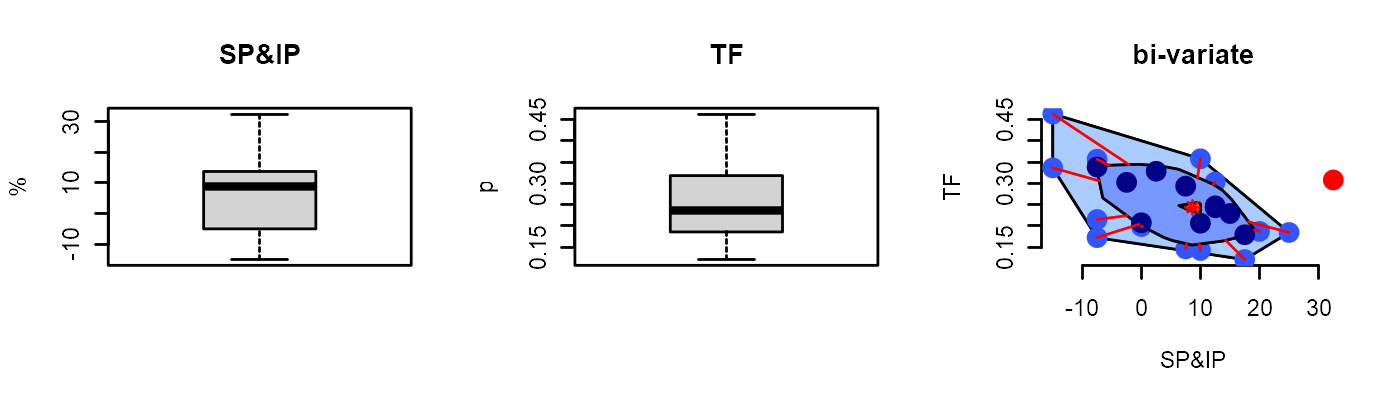

[1] "SP outliers: 1"
[1] 16
[1] "TF outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 1"
[1] 16


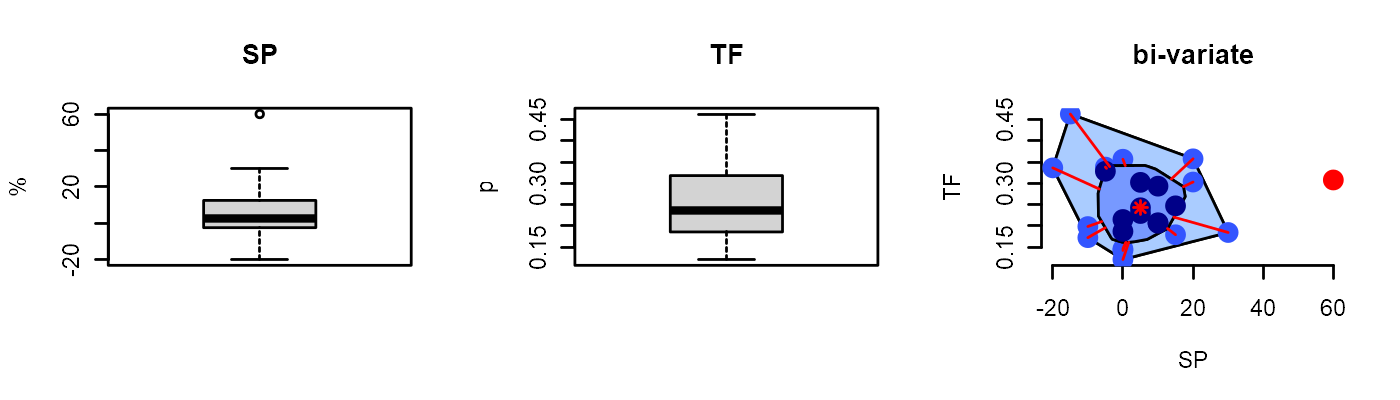

[1] "IP outliers: 0"
numeric(0)
[1] "TF outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


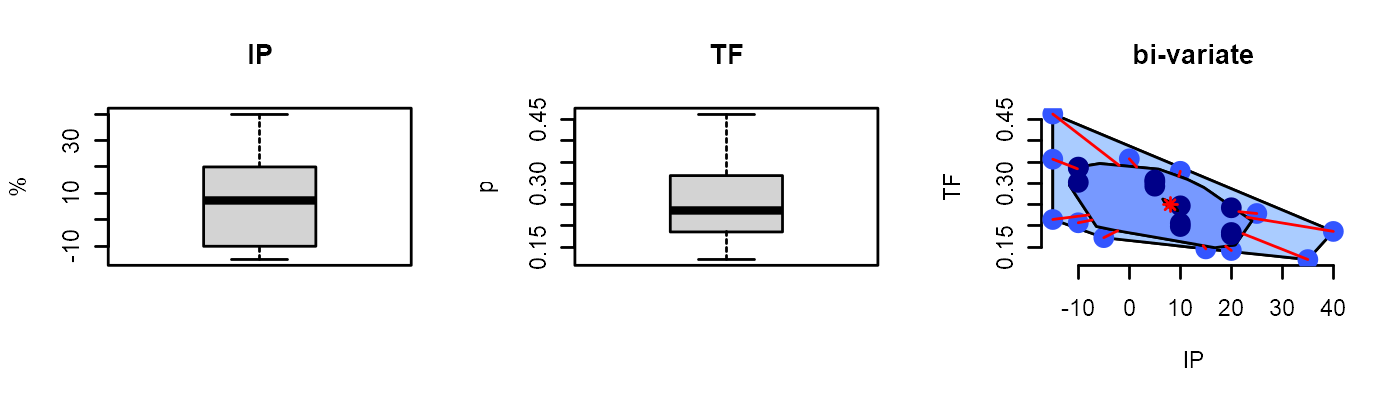

In [21]:
options(repr.plot.width = 7, repr.plot.height = 2, repr.plot.res = 200) # change plot size
u_spipOutl_tf <- get_outliers(dataTNT$spipSIFu, "SP&IP", "%", tf, "TF", "p", disp = TRUE)
u_spOutl_tf   <- get_outliers(dataTNT$spSIFu, "SP", "%", tf, "TF", "p", disp = TRUE)
u_ipOutl_tf   <- get_outliers(dataTNT$ipSIFu, "IP", "%", tf, "TF", "p", disp = TRUE)

#### Outliers with Conditionalised SIF

[1] "SP&IP outliers: 0"
numeric(0)
[1] "TF outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


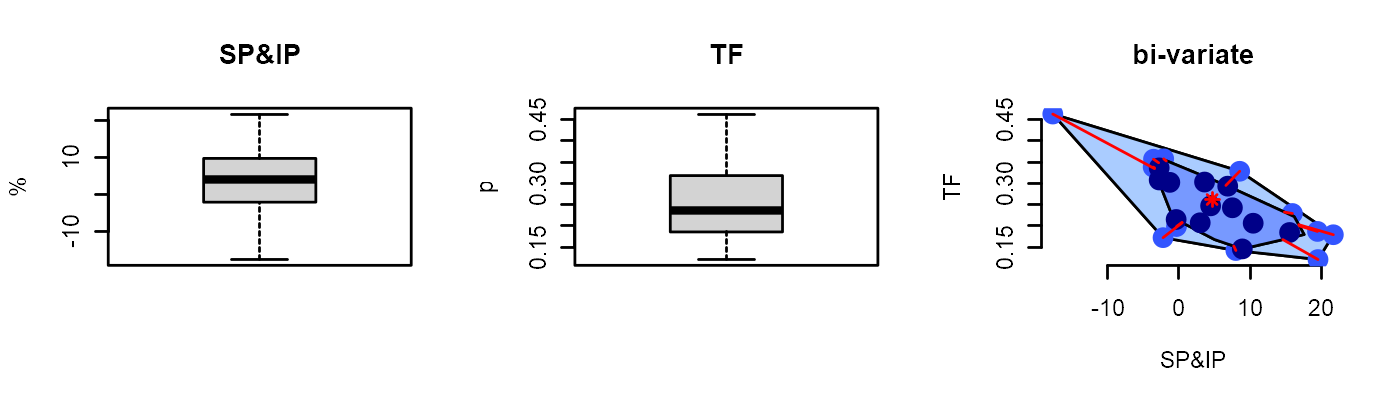

[1] "SP outliers: 1"
[1] 23
[1] "TF outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 1"
[1] 23


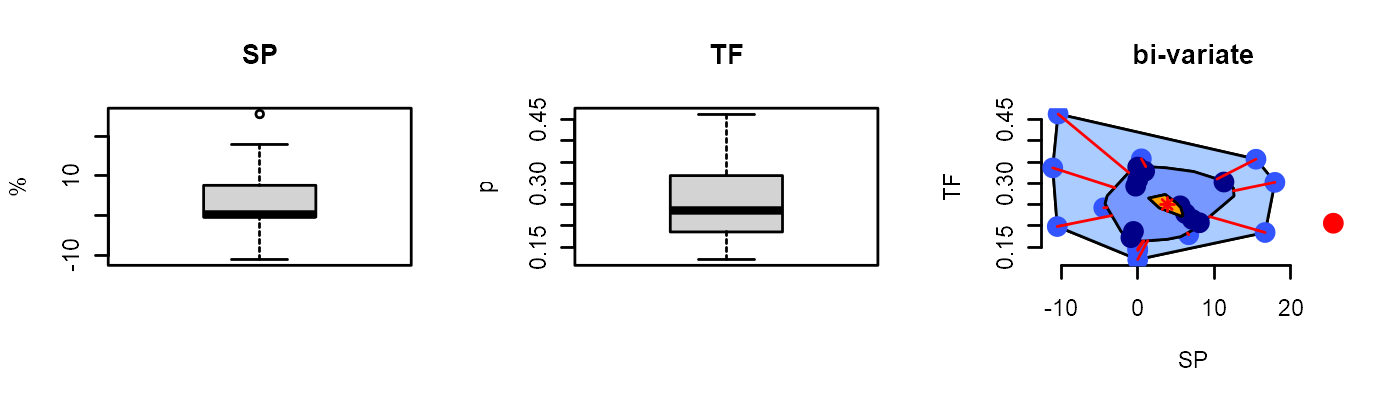

[1] "IP outliers: 0"
numeric(0)
[1] "TF outliers: 0"
numeric(0)
[1] "Bi-variate outliers: 0"
numeric(0)


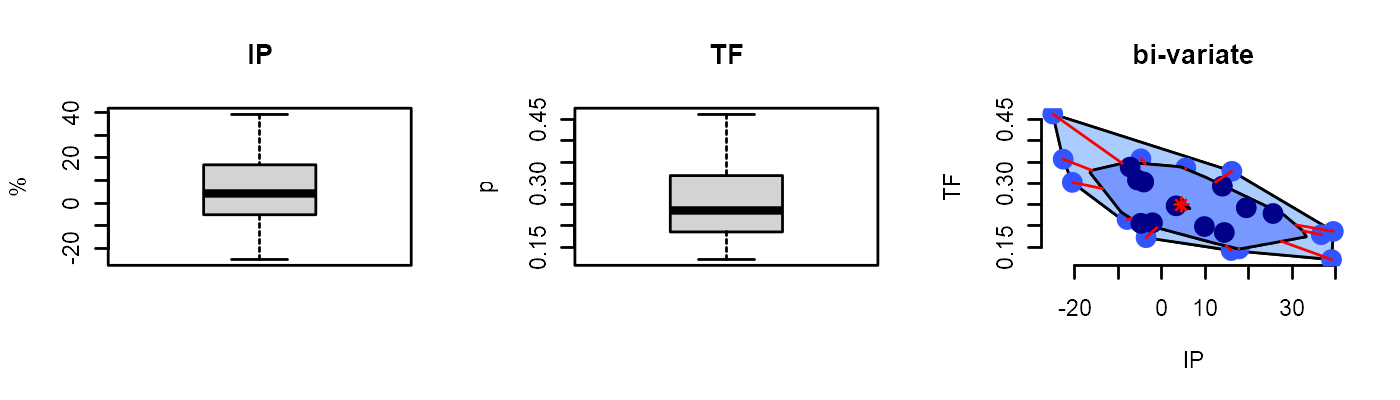

In [22]:
options(repr.plot.width = 7, repr.plot.height = 2, repr.plot.res = 200) # change plot size
c_spipOutl_tf <- get_outliers(dataTNT$spipSIFc, "SP&IP", "%", tf, "TF", "p", disp = TRUE)
c_spOutl_tf   <- get_outliers(dataTNT$spSIFc, "SP", "%", tf, "TF", "p", disp = TRUE)
c_ipOutl_tf   <- get_outliers(dataTNT$ipSIFc, "IP", "%", tf, "TF", "p", disp = TRUE)

### Correlation

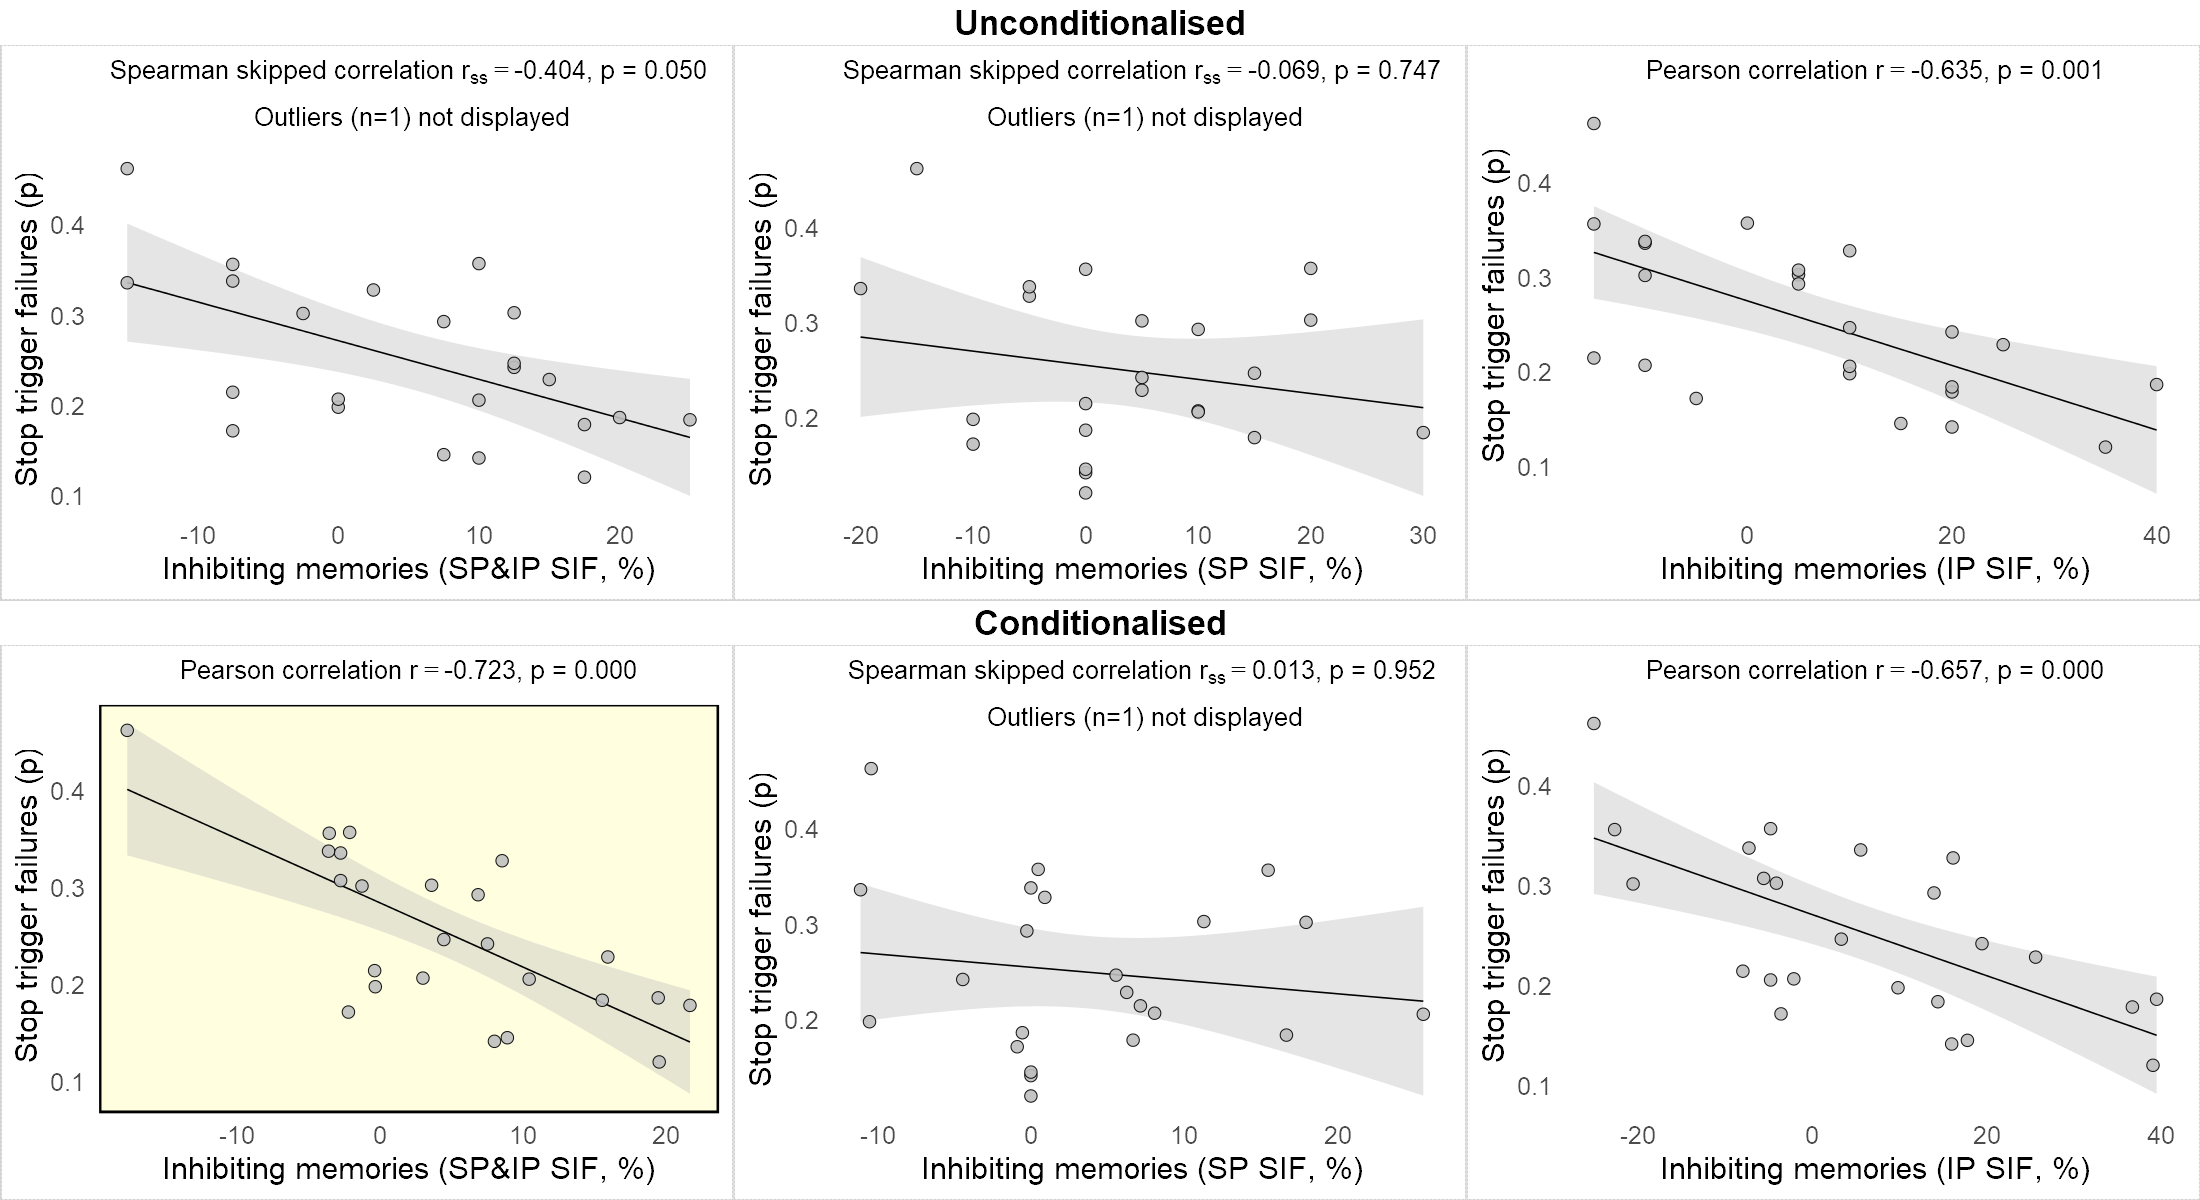

In [23]:
options(repr.plot.width = 11, repr.plot.height = 6, repr.plot.res = 200) # change plot size
grid.arrange(
  arrangeGrob(
    plotCorrelation(dataTNT$spipSIFu,tf,"Inhibiting memories (SP&IP SIF, %)","Stop trigger failures (p)",
                    doCorrelation(dataTNT$spipSIFu, tf, u_spipOutl_tf),
                    1.8, 11, u_spipOutl_tf), 
    plotCorrelation(dataTNT$spSIFu,tf,"Inhibiting memories (SP SIF, %)","Stop trigger failures (p)",
                    doCorrelation(dataTNT$spSIFu, tf, u_spOutl_tf),
                    1.8, 11, u_spOutl_tf), 
    plotCorrelation(dataTNT$ipSIFu,tf,"Inhibiting memories (IP SIF, %)","Stop trigger failures (p)",
                    doCorrelation(dataTNT$ipSIFu, tf, u_ipOutl_tf),
                    1.8, 11, u_ipOutl_tf), 
    top = textGrob("Unconditionalised", gp=gpar(fontface="bold")), 
    nrow = 1),
  
  arrangeGrob(
    plotCorrelation(dataTNT$spipSIFc,tf,"Inhibiting memories (SP&IP SIF, %)","Stop trigger failures (p)",
                    doCorrelation(dataTNT$spipSIFc, tf, c_spipOutl_tf),
                    1.8, 11, c_spipOutl_tf) + theme(panel.background = element_rect(fill = "lightyellow")), 
    plotCorrelation(dataTNT$spSIFc,tf,"Inhibiting memories (SP SIF, %)","Stop trigger failures (p)",
                    doCorrelation(dataTNT$spSIFc, tf, c_spOutl_tf),
                    1.8, 11, u_spOutl_tf), 
    plotCorrelation(dataTNT$ipSIFc,tf,"Inhibiting memories (IP SIF, %)","Stop trigger failures (p)",
                    doCorrelation(dataTNT$ipSIFc, tf, c_ipOutl_tf),
                    1.8, 11, u_ipOutl_tf),
    top = textGrob("Conditionalised", gp=gpar(fontface="bold")), 
    nrow = 1)
)

# ROI analysis: inhibitory targets, hippocampus and M1

In [77]:
library(ggplot2)   # for plotting results
library(tidyr)     # for creating long table (function gather)
library(Rmisc)     # for getting summary data frame
library(gridExtra) # for adding plots together
library(grid)      # for plot grid title formatting
library(plyr)      # for changing factor level names
library(gtools)    # for converting pvalues to stars
# ----------------------------------------------------------------------
# GET THE DATA
# ----------------------------------------------------------------------
data <-
 read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/targetROIs_psc.csv')
dataLong <- gather(data, seconds, psc, X0s:X10s, factor_key = TRUE)

dataLong$inhibit <-
  as.factor(ifelse((
    dataLong$condition == 's' | dataLong$condition == 'nt'
  ), 1, 0))

# subsets
dataLong.rHCTNT <-
  subset(dataLong, roi == 'rHC' &
           (condition == 't' | condition == 'nt'))
dataLong.rHCSG <-
  subset(dataLong, roi == 'rHC' &
           (condition == 'g' | condition == 's'))

dataLong.lM1TNT <-
  subset(dataLong, roi == 'lM1' &
           (condition == 't' | condition == 'nt'))
dataLong.lM1SG <-
  subset(dataLong, roi == 'lM1' &
           (condition == 'g' | condition == 's'))

# ----------------------------------------------------------------------
# ROI x MODALITY INTERACTION
# ----------------------------------------------------------------------
dataInh <- subset(data, (condition == 'nt' | condition == 's'))
dataExp <- subset(data, (condition == 't' | condition == 'g'))

#substract Express from Inhibit
dataModality <- cbind(dataInh[, 1:3], dataInh[, 4:9] - dataExp[, 4:9])

dataModality$condition <- as.factor(dataModality$condition)
# Change conditions to the corresponding Modality
dataModality$condition <-
  revalue(dataModality$condition, c("nt" = "nt_t", "s" = "s_g"))
names(dataModality)[names(dataModality) == 'condition'] <-
  'modality'

# Average PSC within a timespan of 2-8s and substracting the onset value to account for pretrial variability.
# Similar as in Levy&Anderson, 2012 (they did 4-8s)
dataModality$PSC <- rowMeans(dataModality[, 5:8])-dataModality[, 4]

# Get Within-Subject summary
dataModality$roi <- as.factor(dataModality$roi)
dataModality$modality <- as.factor(dataModality$modality)

dataModalitySummary <- summarySEwithin(
      dataModality,
      measurevar = "PSC",
      withinvars = c("roi", "modality"),
      idvar = "sid",
      na.rm = TRUE,
      conf.interval = 0.95
    )

# plot the interaction
p.anova <-
  ggplot(data = dataModality, aes(
    x = roi,
    color = modality,
    group = modality,
    y = PSC
  )) +
  geom_hline(aes(yintercept = 0), size = 0.1) +
  stat_summary(fun = mean, geom = "line", size = 1) +
      
  geom_pointrange(data = dataModalitySummary, 
                aes(y = PSC, ymin = PSC - se, ymax = PSC + se, color = modality),                
                   size = 1, show.legend = FALSE) +

 # stat_summary(
 #   fun.data = mean_se,
 #   geom = "pointrange",
  #  aes(color = modality, fill = modality),
  #  size = 1,
  #  show.legend = FALSE
  #) +
  scale_color_manual(
    labels = c("No-Think - Think", "Stop - Go"),
    values = c('red', '#ffc000')
  ) +
  scale_fill_manual(values = c('red', '#ffc000')) +
  guides(color = guide_legend("")) +
  scale_x_discrete(limits = c("rHC", "lM1"),
                   labels = c("Hippocampus", "M1")) +
  labs(x = "Target region", y = "% signal change difference") +
  ggtitle("Target region x Modality interaction") +
  theme_minimal() +
  theme(
    text = element_text(size = 12),
    plot.title = element_text(hjust = 0.5, size = 12, face = "bold"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    legend.position = "top"
  )

# statistics
summary.anova <-
  summary(res.anova <-
            aov(PSC ~ roi * modality + Error(sid / (roi * modality)), data = dataModality))
res.txt.anova <- sprintf(
  'F(%d,%d) = %.2f, p = %.7f',
  summary.anova[["Error: sid:roi:modality"]][[1]][["Df"]][1],
  summary.anova[["Error: sid:roi:modality"]][[1]][["Df"]][2],
  summary.anova[["Error: sid:roi:modality"]][[1]][["F value"]][1],
  summary.anova[["Error: sid:roi:modality"]][[1]][["Pr(>F)"]][1]
)

# paired t-test of HC vs M1 for NTT
data.ntt.rHC  <- subset(dataModality, roi == 'rHC' & modality == 'nt_t')
data.ntt.lM1  <- subset(dataModality, roi == 'lM1' & modality == 'nt_t')
res.ntt <- t.test(
    data.ntt.rHC$PSC,
    data.ntt.lM1$PSC,
    alternative = c("two.sided"),
    paired = TRUE
  )
res.txt.ntt <- sprintf(
  't(%d) = %.2f, p = %.3f, d = %.3f',
  res.ntt[["parameter"]][["df"]],
  abs(res.ntt[["statistic"]][["t"]]),
  res.ntt[["p.value"]],
  abs(res.ntt[["statistic"]][["t"]] / sqrt(res.ntt[["parameter"]][["df"]] + 1))
)

# paired t-test of HC vs M1 for SG
data.sg.rHC <- subset(dataModality, roi == 'rHC' & modality == 's_g')
data.sg.lM1  <- subset(dataModality, roi == 'lM1' & modality == 's_g')
res.sg <-
  t.test(data.sg.rHC$PSC, data.sg.lM1$PSC, alternative = c("two.sided"), paired = TRUE
  )
res.txt.sg <- sprintf(
    't(%d) = %.2f, p = %.7f, d = %.3f',
    res.sg[["parameter"]][["df"]],
    abs(res.sg[["statistic"]][["t"]]),
    res.sg[["p.value"]], 
    abs(res.sg[["statistic"]][["t"]]/sqrt(res.sg[["parameter"]][["df"]] + 1))
)

# add p value stars to the plot
p.anova <- p.anova +
  annotate(
    "text", x = 1.5, y = mean(dataModality$PSC) + sd(dataModality$PSC),
    label = stars.pval(summary.anova[["Error: sid:roi:modality"]][[1]][["Pr(>F)"]][1]), size = 8
  ) +
  annotate(
    "text", x = 1.38, y = mean(c(mean(data.ntt.rHC$PSC), mean(data.ntt.lM1$PSC))),
    label = stars.pval(res.ntt[["p.value"]]), color = "red", size = 8
  ) +
  annotate(
    "text", x = 1.65, y = mean(c(mean(data.sg.rHC$PSC), mean(data.sg.lM1$PSC))),
    label = stars.pval(res.sg[["p.value"]]), color = "#ffc000", size = 8
  )

## Target region x Modality interaction plot

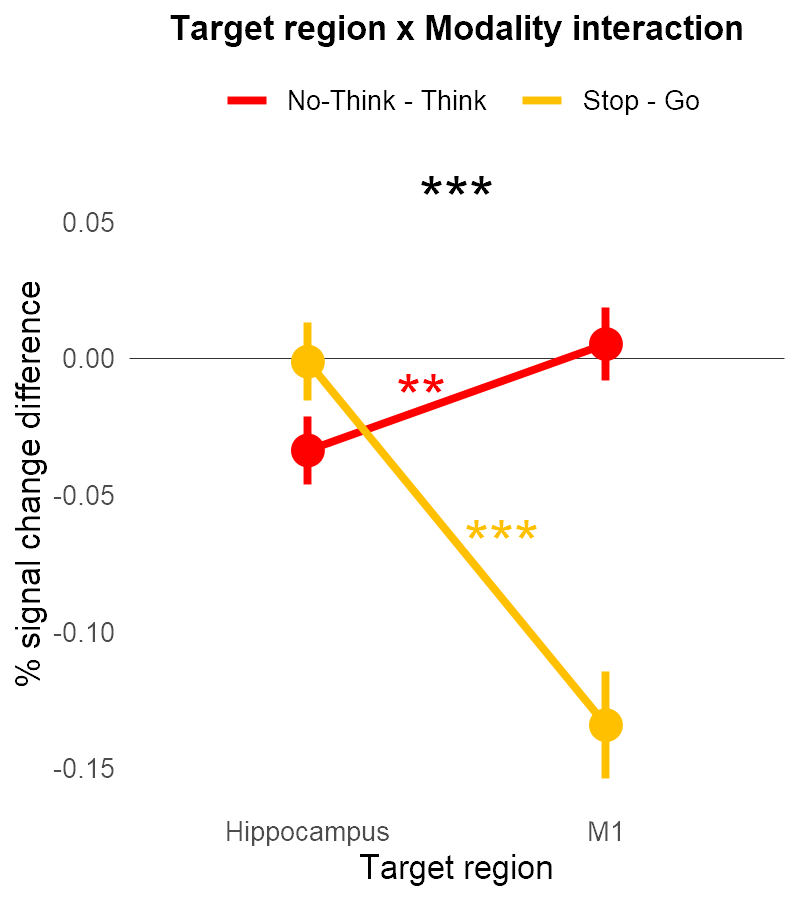

In [81]:
options(repr.plot.width = 4, repr.plot.height = 4.5, repr.plot.res = 200) # change plot size
p.anova

## Target region x Modality ANOVA

In [82]:
summary.anova
res.txt.anova


Error: sid
          Df Sum Sq Mean Sq F value Pr(>F)
Residuals 23 0.2582 0.01123               

Error: sid:roi
          Df  Sum Sq Mean Sq F value   Pr(>F)    
roi        1 0.05308 0.05308   14.28 0.000972 ***
Residuals 23 0.08549 0.00372                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: sid:modality
          Df  Sum Sq Mean Sq F value  Pr(>F)   
modality   1 0.06866 0.06866   7.922 0.00983 **
Residuals 23 0.19934 0.00867                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: sid:roi:modality
             Df  Sum Sq Mean Sq F value   Pr(>F)    
roi:modality  1 0.17737 0.17737   42.71 1.14e-06 ***
Residuals    23 0.09551 0.00415                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

[1] "F(1,23) = 42.71, p = 0.0000011"

### Downregulation of Hippocampus vs M1 for Memory modality

In [72]:
res.ntt
res.txt.ntt


	Paired t-test

data:  data.ntt.rHC$PSC and data.ntt.lM1$PSC
t = -3.2223, df = 23, p-value = 0.003772
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.06393370 -0.01394059
sample estimates:
mean of the differences 
            -0.03893715 


[1] "t(23) = 3.22, p = 0.004, d = 0.658"

### Downregulation of Hippocampus vs M1 for Action modality

In [66]:
res.sg
res.txt.sg


	Paired t-test

data:  data.sg.rHC$PSC and data.sg.lM1$PSC
t = 5.8904, df = 23, p-value = 5.279e-06
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.08628865 0.17970313
sample estimates:
mean of the differences 
              0.1329959 


[1] "t(23) = 5.89, p = 0.0000053, d = 1.202"

## Below baseline activity in Hippocampus and M1

In [83]:
# ----------------------------------------------------------------------
# PLOT FIRs
# ----------------------------------------------------------------------
plotFirs <- function(dataset, labelstxt, title) {
  # aggregate
  res <-
    summarySEwithin(
      dataset,
      measurevar = "psc",
      withinvars = c("seconds", "inhibit"),
      idvar = "sid",
      na.rm = TRUE,
      conf.interval = 0.95
    )
  # plot
  ggplot(data = res, aes(x = seconds, y = psc, group = inhibit)) +
    geom_hline(aes(yintercept = 0), size = 0.2) +
    geom_line(size = 1.5, aes(color = inhibit)) +
    geom_ribbon(
      aes(
        ymin = psc - se,
        ymax = psc + se,
        x = seconds,
        fill = inhibit
      ),
      alpha = 0.3,
      show.legend = FALSE
    ) +
    geom_line(aes(x = seconds, y = psc - se, color = inhibit), size = 0.2) +
    geom_line(aes(x = seconds, y = psc + se, color = inhibit), size = 0.2) +
    scale_color_manual(labels = labelstxt, values = c('green', 'blue')) +
    scale_fill_manual(values = c('#14b814', '#2e599e')) +
    scale_x_discrete(labels = c("0", "2", "4", "6", "8", "10")) +
    labs(x = "Peristimulus time (s)", y = "% signal change") +
    ggtitle(title) +
    guides(color = guide_legend("")) +
    theme_minimal() +
    theme(
      legend.position = "top",
      text = element_text(size = 20),
      plot.title = element_text(
        hjust = 0.5,
        size = 20,
        face = "bold"
      ),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank()
    )
}

p.gs <- plotFirs(dataLong.lM1SG, c("Go", "Stop"), "Go/Stop, M1")
p.tnt <- plotFirs(dataLong.rHCTNT, c("Think", "No-Think"), "Think/No-Think, Hippocampus")

# Add one-tailed significance for > or < baseline
lm1s <- subset(data, roi == 'lM1' & condition == 's')
lm1s$PSC <- rowMeans(lm1s[, 5:8])
p.lm1s <- stars.pval(sapply(c(5:8), function(x) {
  t.test(lm1s[, x], mu = 0, alternative = c("less"))$p.value
}))
lm1g <- subset(data, roi == 'lM1' & condition == 'g')
lm1g$PSC <- rowMeans(lm1s[, 5:8])
p.lm1g <- stars.pval(sapply(c(5:8), function(x) {
  t.test(lm1g[, x], mu = 0, alternative = c("greater"))$p.value
}))

rhcnt <- subset(data, roi == 'rHC' & condition == 'nt')
rhcnt$PSC <- rowMeans(rhcnt[, 5:8])
p.rhcnt <- stars.pval(sapply(c(5:8), function(x) {
  t.test(rhcnt[, x], mu = 0, alternative = c("less"))$p.value
}))

rhct <- subset(data, roi == 'rHC' & condition == 't')
rhct$PSC <- rowMeans(rhct[, 5:8])
p.rhct <- stars.pval(sapply(c(5:8), function(x) {
  t.test(rhct[, x], mu = 0, alternative = c("greater"))$p.value
}))

sstypos <-
  summarySEwithin(
    dataLong.lM1SG,
    measurevar = "psc",
    withinvars = c("seconds", "inhibit"),
    idvar = "sid",
    na.rm = TRUE,
    conf.interval = 0.95
  )
p.gs <- p.gs +
  annotate("text", y = min(sstypos$psc) - mean(sstypos$ci), x = 2:5, label = p.lm1s, size = 10, color = "blue"
  ) +
  annotate(
    "text", y = max(sstypos$psc) + mean(sstypos$ci), x = 2:5, label = p.lm1g, size = 10, color = "green")

tntypos <-
  summarySEwithin(dataLong.rHCTNT, measurevar = "psc", withinvars = c("seconds", "inhibit"),
    idvar = "sid", na.rm = TRUE, conf.interval = 0.95)
p.tnt <- p.tnt +
  annotate(
    "text", y = min(tntypos$psc) - mean(tntypos$ci), x = 2:5, label = p.rhcnt,size = 10, color = "blue"
  ) +
  annotate("text", y = max(tntypos$psc) + mean(tntypos$ci), x = 2:5, label = p.rhct, size = 10, color = "green"
  )

### FIR plots

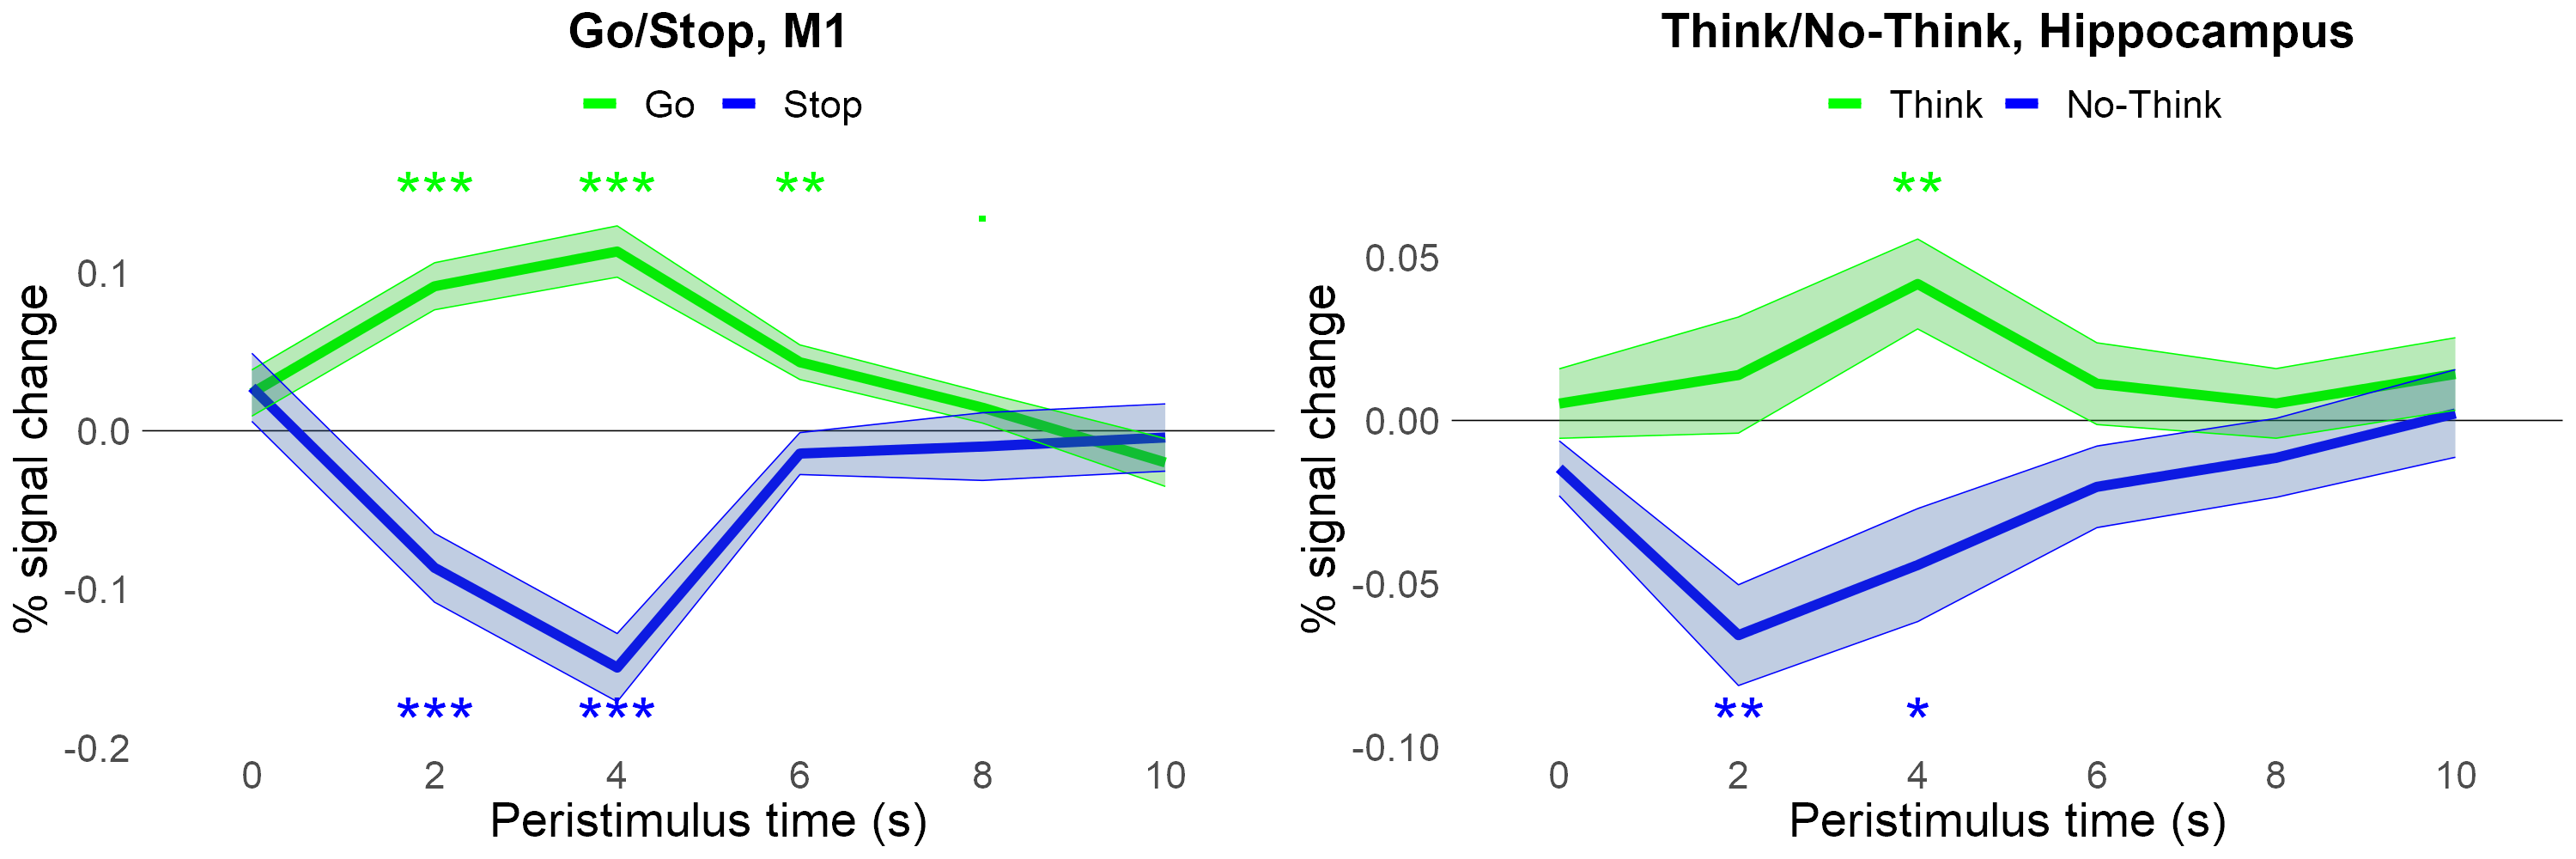

In [84]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 200)
grid.arrange(p.gs, p.tnt, nrow=1)

### M1 below baseline during Stop

In [89]:
data.s.lM1 = subset(data, condition == "s" & roi == "lM1")
data.s.lM1$PSC <- rowMeans(data.s.lM1[, 5:8]) - data.s.lM1[, 4]
tt_sm1 <- t.test(data.s.lM1$PSC, mu = 0, alternative = "less")

sprintf('t(%d) = %.2f, p = %.4f, d = %.3f', 
        tt_sm1$parameter,
        tt_sm1$statistic,
        tt_sm1$p.value,
        abs(tt_sm1$statistic/sqrt(tt_sm1$parameter+1))
)

[1] "t(23) = -3.88, p = 0.0004, d = 0.791"

### Hippocampus below baseline during No-Think

In [93]:
data.nt.rHC = subset(data, condition == "nt" & roi == "rHC")
data.nt.rHC$PSC <- rowMeans(data.nt.rHC[, 5:8]) - data.nt.rHC[, 4]
tt_nthc <- t.test(data.nt.rHC$PSC, mu = 0, alternative = "less")

sprintf('t(%d) = %.2f, p = %.3f, d = %.3f', 
        tt_nthc$parameter,
        tt_nthc$statistic,
        tt_nthc$p.value,
        abs(tt_nthc$statistic/sqrt(tt_nthc$parameter+1))
)

[1] "t(23) = -1.84, p = 0.040, d = 0.375"

# Pattern classification results

## Domain-general and domain-specific representations of inhibition

**Domain-specific component** represents how well the classifier discriminates between Stop and No-Think conditions.

**Domain-general component** represents how well the classifier discriminates between Inhibition and Non-Inhibition conditions independent of modality (training the classifier to discriminate No-Think from Think and testing how well it discriminates Stop from Go, and vice versa). 

In [47]:
library(ggplot2)   # for plotting results
library(gridExtra) # for adding plots together
library(grid)      # for plot grid title formatting
library(gtools)    # for converting pvalues to stars
library(plyr)      # for ddply (aggregating results)
library(ggpubr)    # for adding statistics to plots
library(rstatix)   # for Basic Statistical Tests

df <-
  read.csv(
    'https://raw.githubusercontent.com/dcdace/tmp/master/data/cross_decoding.csv',
    fileEncoding = "UTF-8-BOM"
  )

df <- subset(df, type =='ntssnt' | type=='nts')
df$acc <- df$acc*100

df$roi  <- factor(df$roi, levels=c('rdlpfc', 'rvlpfc', 'rHC', 'lM1'))
df$type <- factor(df$type, levels=c('nts', 'ntssnt'))

# create subsets
nts     <- subset(df, df$type == 'nts')    # Inhibition decoding, domain-special
ntssnt  <- subset(df, df$type == 'ntssnt') # cross-decoding, domain-general

rois  <- levels(df$roi)
nrois <- length(rois)

# Within-Subject summary for errorbars
dataSummary <- summarySEwithin(
      df,
      measurevar = "acc",
      withinvars = c("roi", "type"),
      idvar = "sid",
      na.rm = TRUE,
      conf.interval = 0.95
    )

# PLOT
# ------------------------------------
plot.mvpa <- ggplot(data = df, aes(x = roi, y = acc, group=type)) + 
  geom_hline(aes(yintercept = 50), size = 0.2) +
  
  geom_point(
    colour = "black", alpha = .5,
    aes(fill = type),
    size = 2, stroke = 0.5, shape = 21,
    position = position_jitterdodge()
  ) +
  
  geom_pointrange(data = dataSummary, 
                aes(y = acc, ymin = acc - se, ymax = acc + se, fill = type),                
                   alpha = 1, color = "black", size = 1.5, stroke = 0.5, shape = 21,
                  position = position_dodge(width = .2), show.legend = FALSE) +
  
  scale_fill_manual(values = c("#aad400ff", '#ff00ff'), name = "", 
                    labels = c("Domain-specific component", "Domain-general component"),
                   guide = guide_legend(override.aes = list(
                       alpha = 1, color = "black", size = 5.5, stroke = 0.5, shape = 21))) + 
  
  scale_y_continuous(limits = c(min(df$acc) - sd(df$acc), max(df$acc)),
                     breaks = seq(0, 100, 20)) +
  
  labs(x = "", y = "Classification accuracy (%)") + ggtitle("Inhibition representations") +
  
  scale_x_discrete(labels = c("rDLPFC", "rVLPFC", "Hippocampus","M1")) + 
  
  theme_minimal() +
  
  theme(text = element_text(size = 22), 
        plot.title = element_text(size = 20, face="bold", hjust = 0.5), 
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.position="top"
  ) 

# ADD STATS
# ------------------------------------

# One-sample t-test, > 50%, Bonf. corrected for 4 ROIs

stat.test <- df %>%
  group_by(roi, type) %>%
  t_test(acc ~ 1, mu = 50, alternative = "greater") %>%
  adjust_pvalue() %>%
  mutate(y.position = 20)

stat.test$stars <- stars.pval(ifelse(stat.test$p*4 > 1, 1, stat.test$p*4))
stat.test$colors <- ifelse(stat.test$type == "nts", '#669c00ff', '#ff00ff')

plot.mvpa <- plot.mvpa + 
  stat_pvalue_manual(stat.test, label = "stars", x = "roi", 
                     position = position_dodge(0.8), size = 10, color = stat.test$colors)


# t-test function
dottest <- function(data) {
  test <- t.test(data$acc, mu = 50, alternative = 'greater')
  
  # correct p-value for number of rois tested and keep max p to 1
  test$p.value <-
    ifelse(test$p.value * nrois > 1, 1, test$p.value * nrois)
  
  return(data.frame(
    tval = test$statistic,
    df   = test$parameter[1],
    pval = test$p.value,
    M    = mean(data$acc),
    std = sd(data$acc)
  ))
}

# do ttests per ROI for each subset of dataset
tres <- sapply(list(nts, ntssnt), function(x) {
  ddply(x, .(roi), dottest)
})

dispresults <- function(res) {
  txt <- lapply(seq(1:nrois), function(r) {
    sprintf(
      "%s: M = %.0f%% (+-%.0f), t(%d) = %.2f, p = %.3f, d = %.3f",
      res$roi[r],
      res$M[r],
      res$std[r],
      res$df[r],
      res$tval[r],
      res$pval[r],
      res$tval[r] / sqrt(res$df[r] + 1)
    )
  })
  txtBind <- (ldply(txt, "rbind", .id = "roi"))
}

resdf <- 
  as.data.frame(cbind(dispresults(tres[, 1]), dispresults(tres[, 2])))
colnames(resdf) <- 
  c("domain-specific", "domain-general")
resdf


Warning message in if (color %in% colnames(data)) mapping$colour <- rlang::ensym(color) else option$color <- color:
"the condition has length > 1 and only the first element will be used"


domain-specific,domain-general
<chr>,<chr>
"rdlpfc: M = 69% (+-18), t(23) = 5.09, p = 0.000, d = 1.039","rdlpfc: M = 57% (+-10), t(23) = 3.48, p = 0.004, d = 0.711"
"rvlpfc: M = 74% (+-12), t(23) = 10.10, p = 0.000, d = 2.062","rvlpfc: M = 60% (+-12), t(23) = 3.93, p = 0.001, d = 0.802"
"rHC: M = 62% (+-9), t(23) = 6.59, p = 0.000, d = 1.346","rHC: M = 50% (+-9), t(23) = 0.23, p = 1.000, d = 0.046"
"lM1: M = 65% (+-10), t(23) = 6.85, p = 0.000, d = 1.399","lM1: M = 48% (+-8), t(23) = -1.15, p = 1.000, d = -0.235"


### Pair-wise comparisons of domain-specific vs. domain-general components (Bonf. corrected for nr of ROIs)

In [48]:
# ------------------------------------
# Paired t-tests, Bonf. corrected for 4 ROIs
# paired ttest of domain-general vs domain-specific

pairedttest <- function(data1, data2){
  test <- t.test(data1$acc, data2$acc, paired = TRUE)
  
  # correct p-value for number of rois tested
  test$p.value <- ifelse(test$p.value * nrois > 1, 1, test$p.value * nrois)
  
  return(
    data.frame(
      tval = test$statistic,
      df = test$parameter[1],
      pval = test$p.value,
      M = mean(data1$acc) - mean(data2$acc)
    ))
}

ptests <- sapply(seq(1:nrois), function(x){
  pairedttest(subset(nts, roi == rois[x]), subset(ntssnt, roi == rois[x]))
})

# get stars for pvalues
sig <- sapply(seq(1:nrois), function(x){
  stars.pval(ptests[,x]$pval)})

#add significance stars to the plot
plot.mvpa <- plot.mvpa + 
  annotate("text", y = min(df$acc)-sd(df$acc), x = 1:4, label = sig, size = 10, color = "darkgrey")

txt <- lapply(seq(1:nrois), function(x) {
  sprintf(
    "%s: M = %.0f%%, t(%d) = %.2f, p = %.3f, d = %.3f",
    rois[x],
    ptests[,x]$M,
    ptests[,x]$df,
    ptests[,x]$tval,
    ptests[,x]$pval,
    ptests[,x]$tval / sqrt(ptests[,x]$df + 1)
  )
})
ldply(txt, "rbind", .id = "roi")

1
<chr>
"rdlpfc: M = 12%, t(23) = 2.69, p = 0.052, d = 0.550"
"rvlpfc: M = 15%, t(23) = 4.07, p = 0.002, d = 0.831"
"rHC: M = 11%, t(23) = 5.90, p = 0.000, d = 1.205"
"lM1: M = 16%, t(23) = 5.53, p = 0.000, d = 1.129"


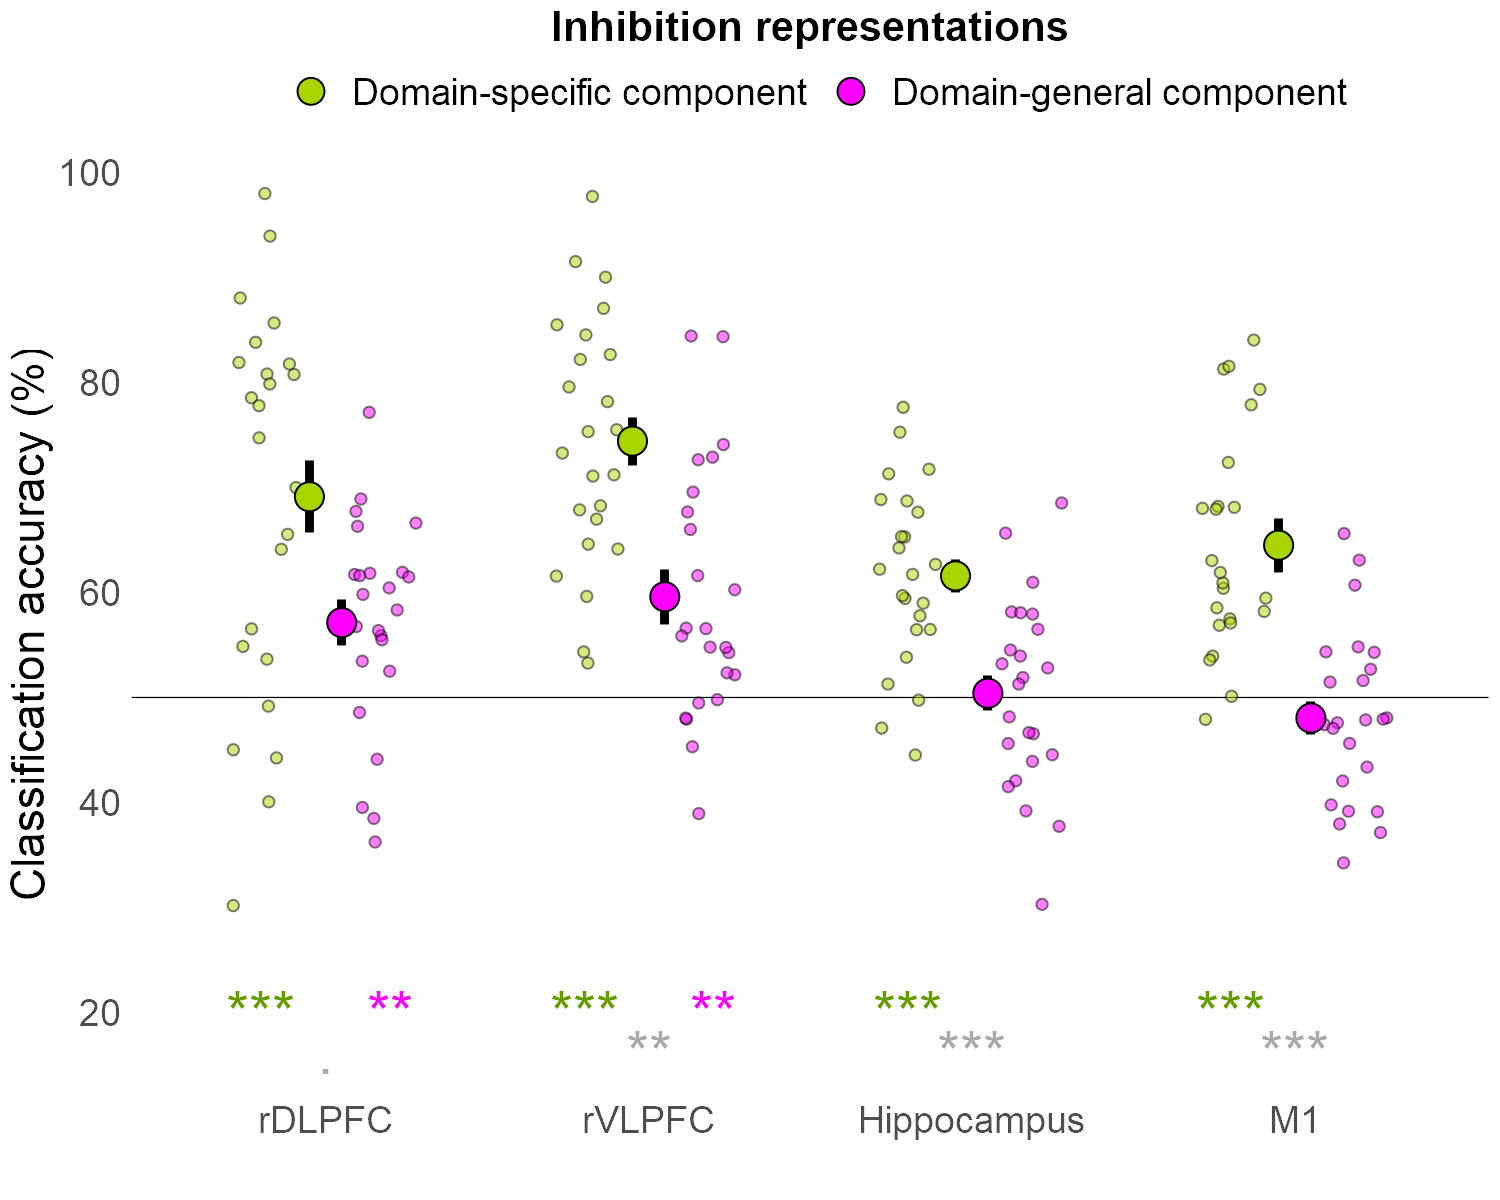

In [49]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 150)
plot.mvpa

## NT is Stop rather than Go, per run

In [36]:
plotAcc <- function(dataset, labelstxt, title) {
  # aggregate
  res1 <- dataset %>% # this is to get correct means, ignoring NaNs
     group_by(run) %>%
     get_summary_stats(acc, type = "mean")
  res2 <- # this is to get within-subject SEs
   summarySEwithin(
      dataset,
      measurevar = "acc",
      withinvars = c("run"),
      idvar = "sNR",
      na.rm = TRUE,  
      conf.interval = 0.95, 
    )
    res <- data.frame(run = res1$run, acc = res1$mean, se = res2$se)   
    #print(res)
  # plot
  ggplot(data = res, aes(x = run, y = acc, group=1)) +
    geom_hline(aes(yintercept = 0.5), size = 0.2, color = "red") +
    geom_line(size = 0.5) +
    geom_point() +
    geom_ribbon(
      aes(
        ymin = acc - se,
        ymax = acc + se,
        x = run
      ),
      alpha = 0.3,
      fill = 'grey',     
      show.legend = FALSE
    ) +
    geom_line(aes(x = run, y = acc - se), size = 0.1) +
    geom_line(aes(x = run, y = acc + se), size = 0.1) +
    labs(x = "Run", y = "Classification accuracy") +
    geom_text(aes(label = round(acc,2)), vjust = -1.5) +
    ggtitle(title) +
    guides(color = guide_legend("")) +
    theme_minimal() +
    theme(
      legend.position = "top",
      text = element_text(size = 14),
      plot.title = element_text(
        hjust = 0.5,
        size = 14,
        face = "bold"
      ),
      panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(), 
        plot.background = element_rect(colour = "lightgrey", size = 0.4, linetype = "dotted")
    )
}
## Per-sun accuracies
perRunResults <- function(data){
    Slope <- data$propslope
    SIF   <- data$SIF
    SSRT  <- data$SSRT
    sNR   <- data$sNR

    df <- gather(data, run, acc, run1:run8, factor_key = TRUE)
    df$sNR <- as.factor(df$sNR)
    #----------------
    ## ANOVA
    contrasts(df$run) <- contr.poly
    res.aov <- aov(acc ~ run + Error(sNR), data = df)
    print(summary(res.aov, split = list(run = list(Linear = 1))))
    
    ## PLOT    
    p <- plotAcc(df, c("Runs"), "")
    grid.arrange(p, nrow=1)
    
    ## OUTLIERS
    sif_slope_outliers <- get_outliers(SIF, "SIF", "%", Slope, "Slope", "", disp = FALSE)
    ssrt_slope_outliers <- get_outliers(SSRT, "SSRT", "%", Slope, "Slope", "", disp = FALSE)
    
    ## CORRELATIONS
    # SIF/Slope
    p1 <- plotCorrelation(SIF, Slope,"Inhibiting memories (SIF, %)","Accuracy slope",
                    doCorrelation(SIF, Slope, sif_slope_outliers),
                    1.8, 11, sif_slope_outliers)
    
    #SSRT/Slope
    p2 <- plotCorrelation(SSRT, Slope,"Inhibiting actions (SSRT, ms)","Accuracy slope",
                    doCorrelation(SSRT, Slope, ssrt_slope_outliers),
                    1.8, 11, ssrt_slope_outliers)
    
    grid.arrange(p1, p2, nrow=1)
    }

In [37]:
ccdata <- read.csv('https://raw.githubusercontent.com/dcdace/tmp/master/data/perRunCrossClassification.csv')
ccdata_rDLPFC <- subset(ccdata, ROI == 'rDLPFC')
ccdata_rVLPFC <- subset(ccdata, ROI == 'rVLPFC')
ccdata_HC     <- subset(ccdata, ROI == 'HC')
ccdata_M1     <- subset(ccdata, ROI == 'M1')

### rDLPFC


Error: sNR
              Df Sum Sq Mean Sq F value Pr(>F)
run            2 0.1957 0.09787   0.757  0.482
  run: Linear  1 0.1908 0.19083   1.475  0.238
Residuals     21 2.7164 0.12935               

Error: Within
               Df Sum Sq Mean Sq F value  Pr(>F)   
run             7  2.623  0.3747   2.517 0.01765 * 
  run: Linear   1  1.666  1.6659  11.189 0.00103 **
Residuals     157 23.375  0.1489                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


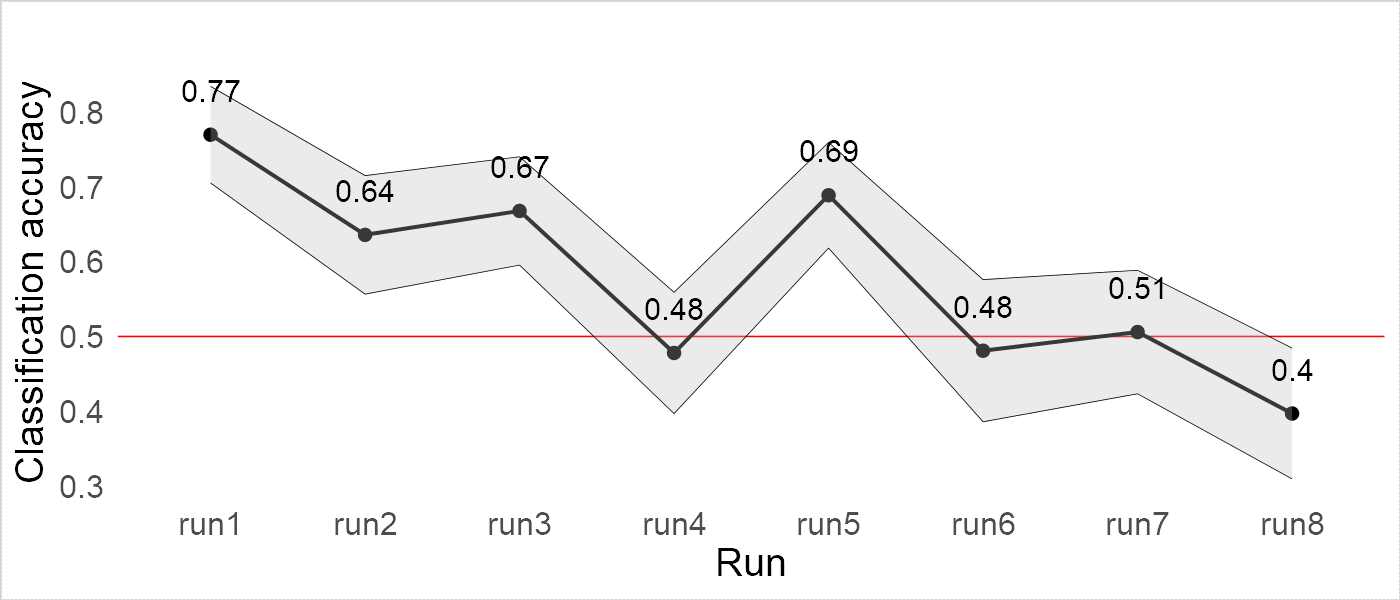

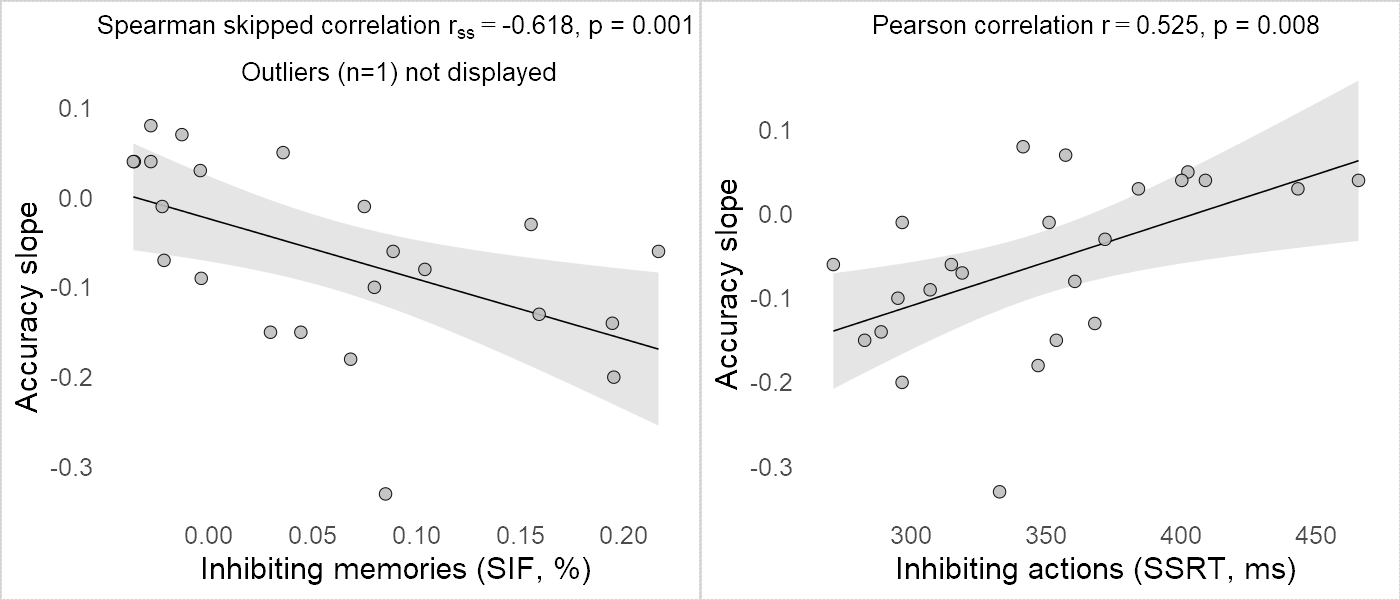

In [38]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 200)
perRunResults(ccdata_rDLPFC)

### rVLPFC


Error: sNR
              Df Sum Sq Mean Sq F value  Pr(>F)   
run            2  1.128  0.5640   7.261 0.00401 **
  run: Linear  1  1.126  1.1256  14.489 0.00103 **
Residuals     21  1.631  0.0777                   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: Within
               Df Sum Sq Mean Sq F value Pr(>F)  
run             7  1.844  0.2634   1.502 0.1703  
  run: Linear   1  0.533  0.5332   3.040 0.0832 .
Residuals     157 27.531  0.1754                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


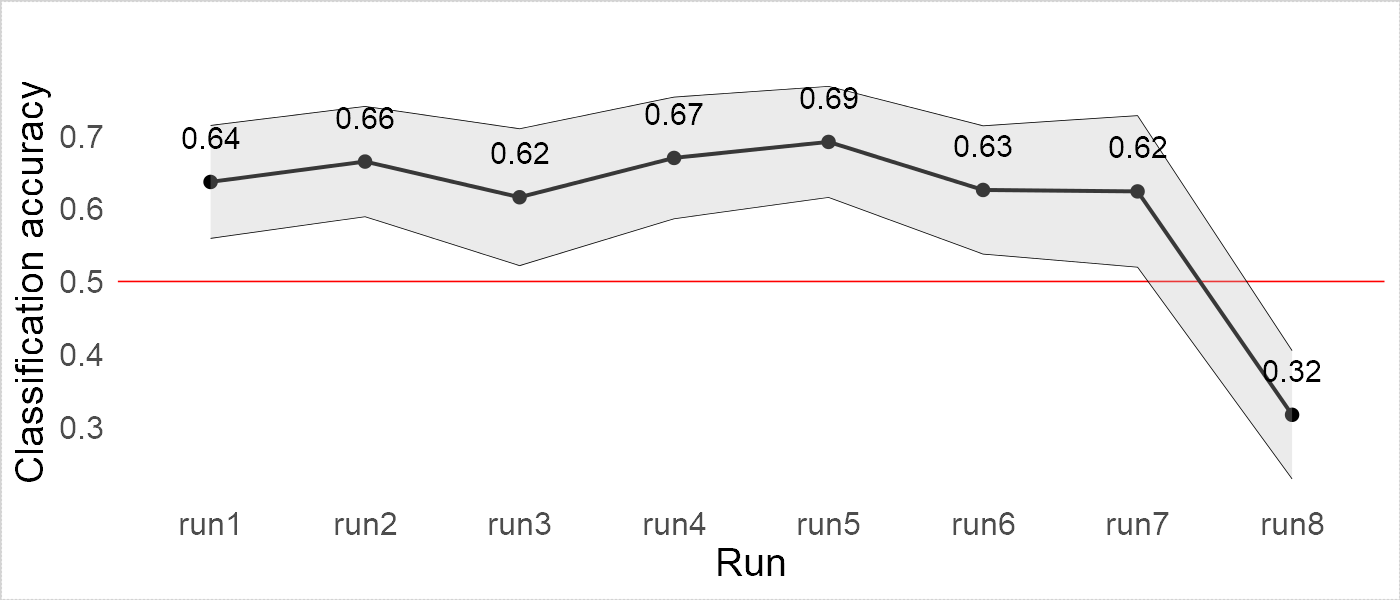

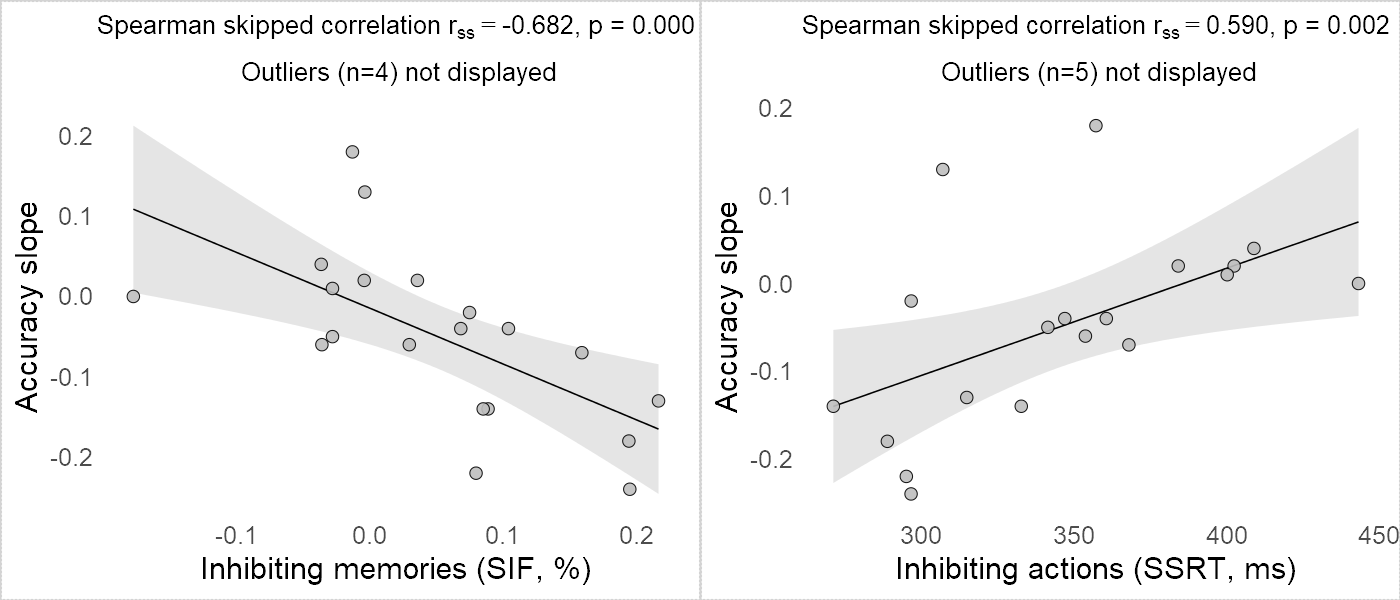

In [39]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 200)
perRunResults(ccdata_rVLPFC)

### Hippocampus


Error: sNR
              Df Sum Sq Mean Sq F value Pr(>F)  
run            2 0.6422  0.3211   2.377 0.1173  
  run: Linear  1 0.5835  0.5835   4.319 0.0501 .
Residuals     21 2.8368  0.1351                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Error: Within
               Df Sum Sq Mean Sq F value Pr(>F)
run             7   1.48  0.2114   1.015  0.423
  run: Linear   1   0.26  0.2621   1.258  0.264
Residuals     157  32.72  0.2084               


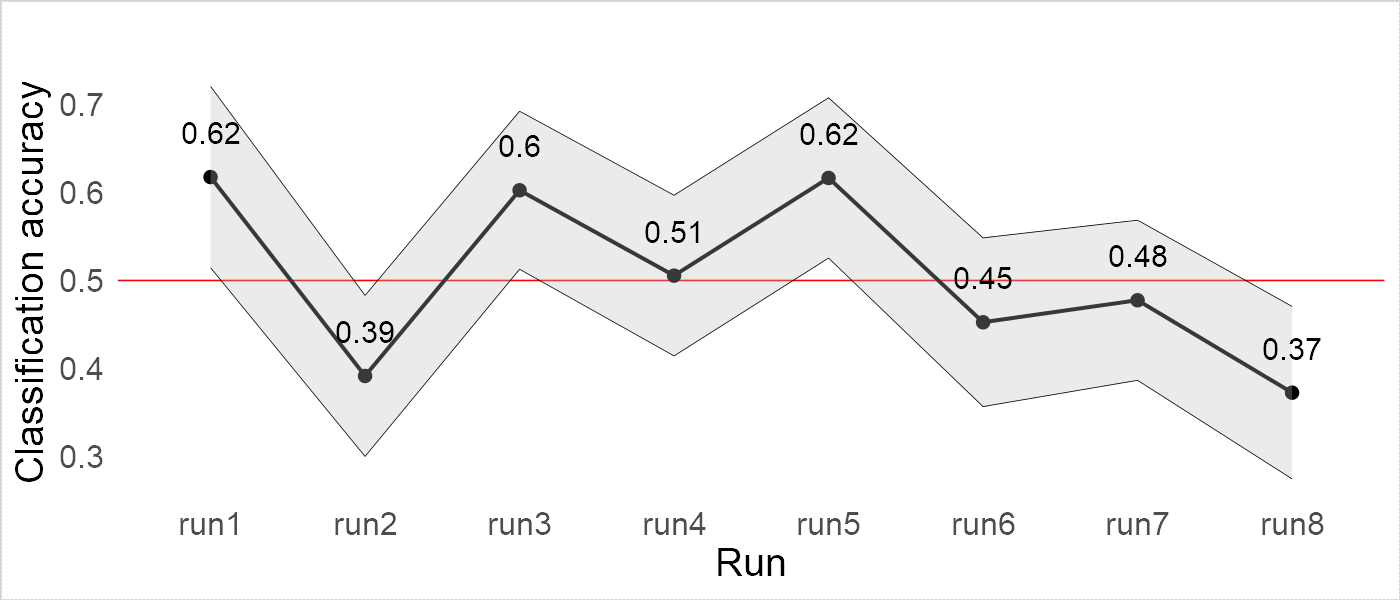

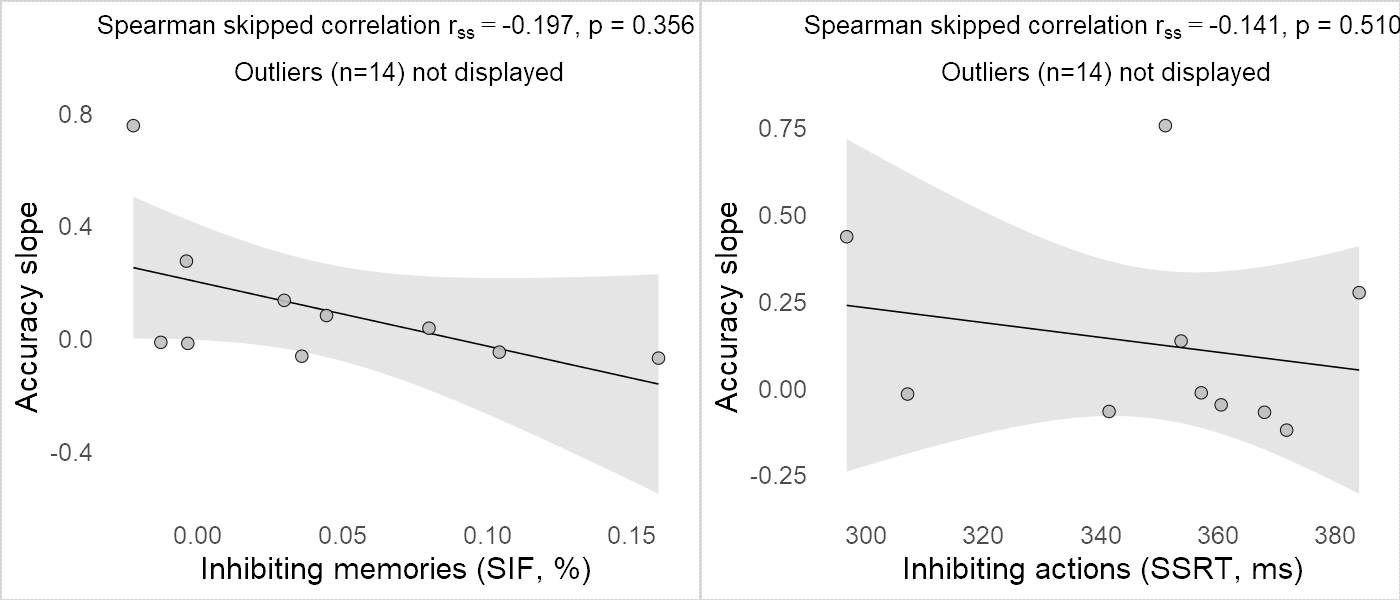

In [40]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 200)
perRunResults(ccdata_HC)

### M1


Error: sNR
              Df Sum Sq Mean Sq F value Pr(>F)
run            2 0.2580 0.12902   1.281  0.299
  run: Linear  1 0.0779 0.07786   0.773  0.389
Residuals     21 2.1152 0.10072               

Error: Within
               Df Sum Sq Mean Sq F value Pr(>F)
run             7  0.651 0.09302   0.597  0.758
  run: Linear   1  0.112 0.11236   0.721  0.397
Residuals     157 24.465 0.15583               


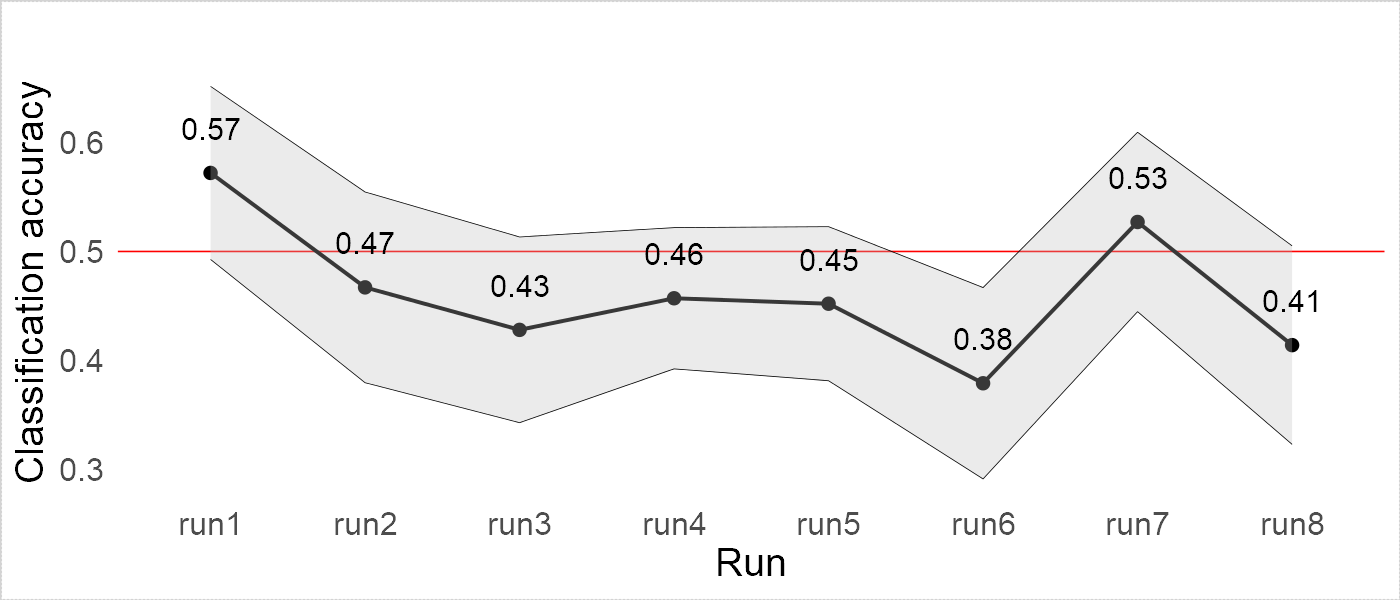

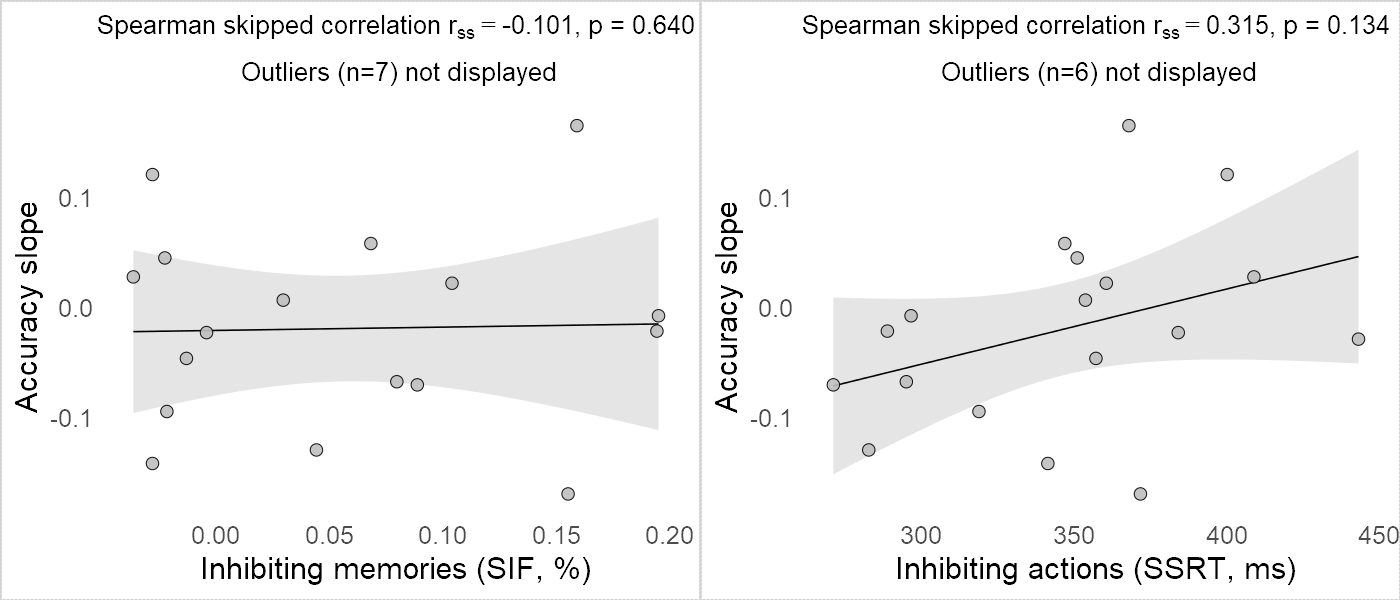

In [41]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 200)
perRunResults(ccdata_M1)

# DCM results

In [50]:
library(ggplot2)    # for plotting results
library(cowplot)    # for adding plots together and setting different widths

# ==================================================================
# NULL & PATHWAYS
# ==================================================================
family <-
  data.frame(
    model = c("01", "02", "03", "04", "05"), 
    xp = c(0, 0, 0.0001, 0.0002, 0.9997) 
  )

bp1 <- ggplot(data = family, aes(x = model, y = xp)) +
  geom_bar(
    stat = "identity",
    color = "black",
    fill = "darkgrey",
    alpha = 0.3,
    lwd = 0.5
  ) +
  geom_text(
    aes(x = model, y = xp + 0.03, label = round(xp, 4)),
    size = 4) +
  scale_y_continuous("Exceedance probability",
                     limits = c(0, 1.03),
                     breaks = seq(0, 1, 0.2)) +
  scale_x_discrete(labels = c("Null", "Independent", "DLPFC", "VLPFC", "Both"), 
                   "Null & Pathways") +
  theme_classic(base_size = 14) + 
  theme(axis.line = element_line(size = 0.5), 
        axis.ticks = element_line(size = 0.5),
        axis.text.x = element_text(angle = 15))

# ==================================================================
# Directions
# ==================================================================
family <-
  data.frame(
    model = c("01", "02", "03", "04"), 
    xp = c(0.001, 0.112, 0.019, 0.868) 
  )

bp2 <- ggplot(data = family, aes(x = model, y = xp)) +
  geom_bar(
    stat = "identity",
    color = "black",
    fill = "grey",
    alpha = 0.3,
    lwd = 0.5
  ) +
  geom_text(
    aes(x = model, y = xp + 0.03, label = round(xp, 3)),
    size = 4) +
  scale_y_continuous("Exceedance probability",
                     limits = c(0, 1.03),
                     breaks = seq(0, 1, 0.2)) +
  scale_x_discrete(labels = 
                     c("None", 
                       expression("DLPFC" %->% "VLPFC"), 
                       expression("DLPFC" %<-% "VLPFC"), 
                       expression("DLPFC" %<->% "VLPFC")), 
                   "Directions") +
  theme_classic(base_size = 14) + 
  theme(axis.line = element_line(size = 0.5), 
        axis.ticks = element_line(size = 0.5),
        axis.text.x = element_text(angle = 15))

# ==================================================================
# TARGETS
# ==================================================================
family <-
  data.frame(
    model = c("01", "02"), 
    xp = c(0.885, 0.115 
    )
  )

bp3 <- ggplot(data = family, aes(x = model, y = xp)) +
  geom_bar( 
    stat = "identity",
    color = "black",
    fill = "lightgrey",
    alpha = 0.3,
    lwd = 0.5
  ) + 
  geom_text(
    aes(x = model, y = xp + 0.03, label = round(xp, 3)),
    size = 4) +
  scale_y_continuous("Exceedance probability",
                     limits = c(0, 1.03),
                     breaks = seq(0, 1, 0.2)) +
  scale_x_discrete(labels = c("Preferred", "Non-preferred"), "Targets") +
  theme_classic(base_size = 14) + 
  theme(axis.line = element_line(size = 0.5), 
        axis.ticks = element_line(size = 0.5),
        axis.text.x = element_text(angle = 15))

# ==================================================================
# ALL MODELS
# ==================================================================
all_models <-
  data.frame(
    model = c(
      "0",
      "01",
      "02",
      "03",
      "04",
      "05",
      "06",
      "07",
      "08",
      "09",
      "10",
      "11",
      "12",
      "13",
      "14",
      "15",
      "16",
      "17",
      "18"
    ), 
    xp = c(
      0.0004,
      0.0002,
      0.0007,
      0.0021,
      0.0005,
      0.0006,
      0.0005,
      0.0058,
      0.0033,
      0.9066,
      0.0002,
      0.0001,
      0.0019,
      0.0000,
      0.0033,
      0.0002,
      0.0527,
      0.0143,
      0.0066
    )
  )

bp4 <- ggplot(data = all_models, aes(x = model, y = xp)) +
  geom_bar(
    stat = "identity",
    color = "black",
    fill = "grey",
    alpha = 0.3,
    lwd = 0.5
  ) +
  geom_text(aes(x = model, y = xp + 0.03,
                label = round(xp, 3)
  ),
  size = 4) +
  scale_y_continuous("Exceedance probability",
                     limits = c(0, 1.03),
                     breaks = seq(0, 1, 0.2)) +
  scale_x_discrete(
    "Models",
    labels = c(
      "0",
      "1",
      "2",
      "3",
      "4",
      "5",
      "6",
      "7",
      "8",
      "9",
      "10",
      "11",
      "12",
      "13",
      "14",
      "15",
      "16",
      "17",
      "18"
    )
  ) +
  theme_classic(base_size = 14) + 
  theme(axis.line = element_line(size = 0.5), 
        axis.ticks = element_line(size = 0.5))

## Model families

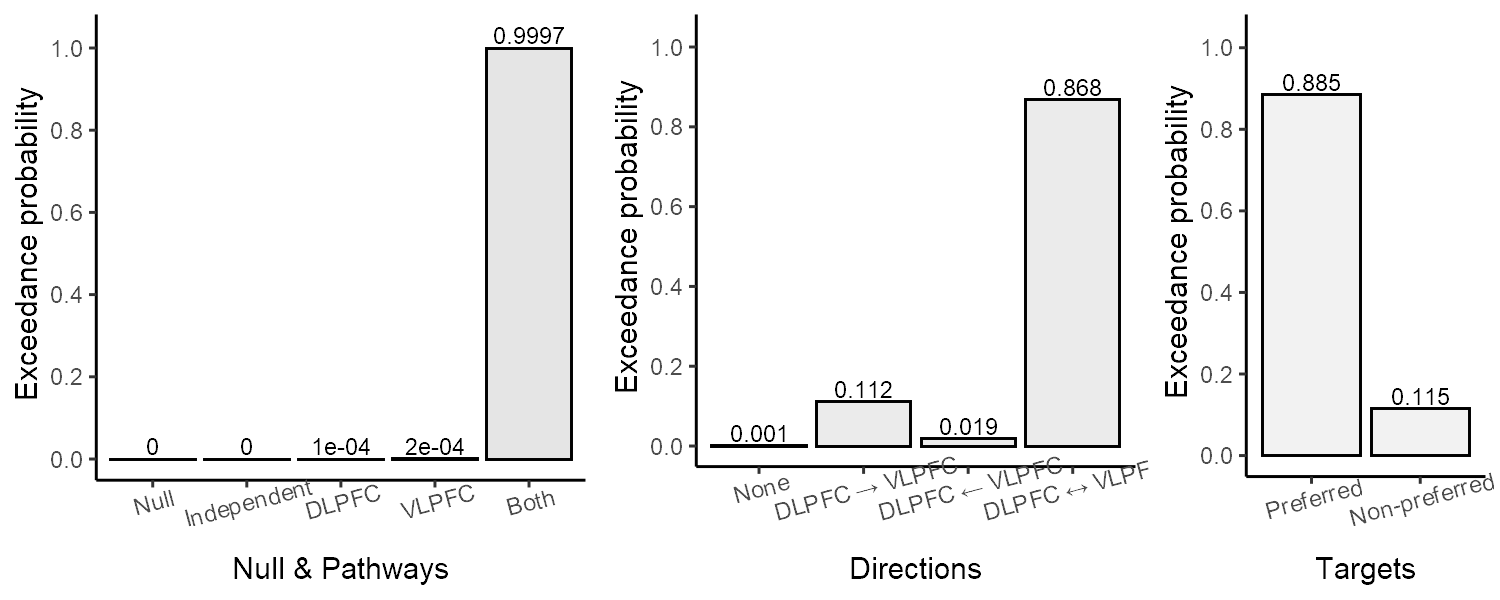

In [43]:
# ==================================================================
# PLOT FAMILIES
# ==================================================================
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 150)
plot_grid(bp1, bp2, bp3, nrow = 1, rel_widths = c(6/15,5.5/15,3.5/15))

## All models

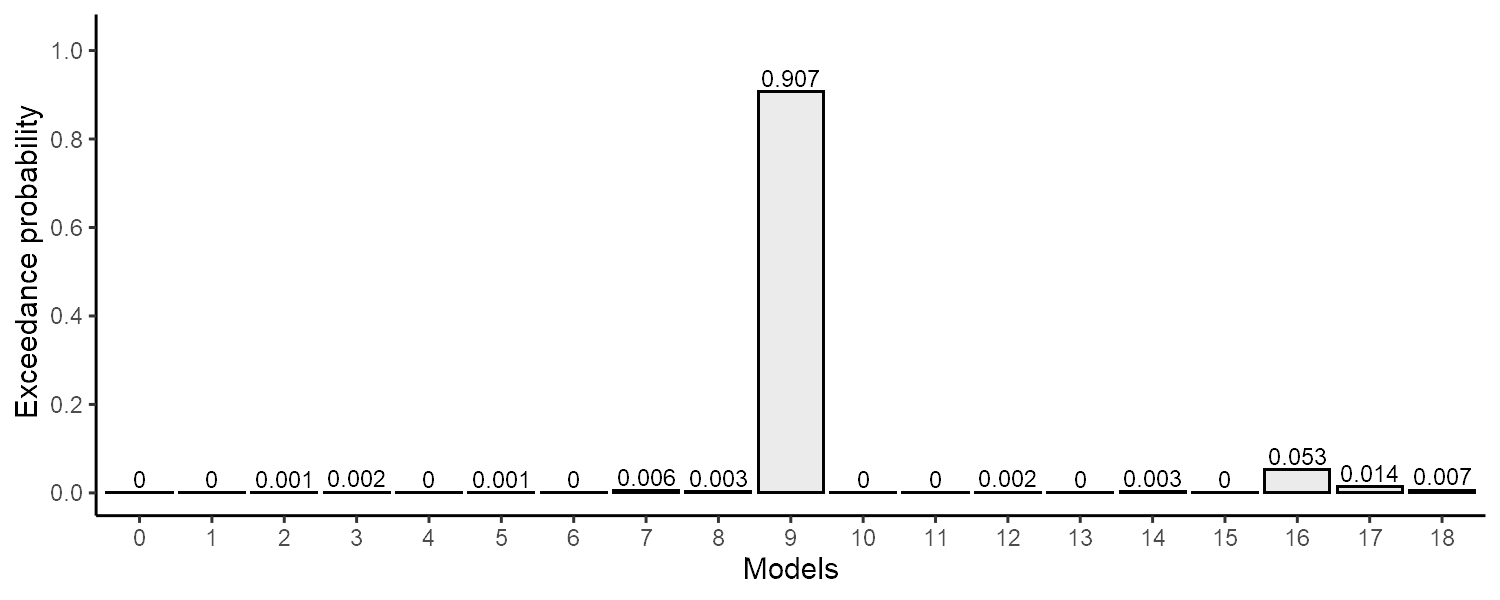

In [44]:
# ==================================================================
# PLOT ALL MODELS
# ==================================================================
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 150)
bp4

In [45]:
# reset to defult plot size
options(repr.plot.width = 7, repr.plot.height = 7)